# Financial-Risk-Analysis

# Imports

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline as sklearnPipeline
from sklearn.compose import ColumnTransformer

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, make_scorer, confusion_matrix
from sklearn.metrics import roc_curve as sklearn_roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_predict, cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

# Functions

In [36]:
def check_nulls_dupes(df):
  print(f"The amount of nulls: {df.isna().sum()}")
  print(f"The amount of Dupes: {df.duplicated().sum()}")

def check_class_imbalance(target, col):
  unique, counts = np.unique(target, return_counts=True)
  
  plt.figure(figsize=(10, 7))
  plt.pie(counts, labels=unique, startangle=140, autopct="%1.1f%%")
  plt.title(f"Target Class {col}")
  plt.legend()
  plt.show()

def plot_distribution(df, kind):
  
  plt.figure(figsize=(16,16))
  rows = len(df.columns)
  dims = (rows+ 3)//4
  for idx, col in enumerate(df.columns):
    plt.subplot(dims, 4, idx+1)
    sns.histplot(df[col], kde=True) if kind == "Hist" else plt.boxplot(df[col])
    plt.title(f"Distribuition of {col}")
    plt.ylabel("Counts")
  plt.tight_layout()
  plt.show()

def aggregate_dataset(df, interested_columns, agg_col, function):
  
  plt.figure(figsize=(20, 20))
  rows = len(interested_columns)
  dims = (rows + 3 )//4
  
  for idx, col in enumerate(interested_columns):
    if col == agg_col:
      continue
    grouped_df = getattr(df.groupby(agg_col)[col], function)().reset_index(name=col)
    plt.subplot(dims, 4, idx+1)
    sns.barplot(data=grouped_df, x=agg_col, y=col)
    plt.title(f"Agg of {col}")
    plt.ylabel(col)
    plt.xticks(rotation =45)
  
  plt.tight_layout()
  plt.show()

def plot_confusion_matrix(y_true, y_pred, model_name):
  
  plt.figure(figsize=(10, 7))
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(data=cm, annot=True, fmt="d", cmap="Blues")
  plt.title(f"Confusion Matrix For: {model_name}")
  plt.ylabel("Predicted Labels")
  plt.xlabel("True Labels")
  plt.show()

def scatter_plot(df, interested_columns, target):
  
  plt.figure(figsize=(12,15))
  columns = len(df.columns)
  rows = (columns + 3) //4
  
  for idx, col in enumerate(interested_columns):
    if col == target:
      continue
    plt.subplot(rows ,4, idx+1)
    sns.scatterplot(data=df, x=target, y=col, hue=col)
  plt.tight_layout()
  plt.show()

def create_column_transformer(cat_cols, numeric_cols):
  
  cat_transformer = sklearnPipeline(
    steps=[
      ("encoder", OneHotEncoder())
    ]
  )
  
  numeric_transformer = sklearnPipeline(
    steps =[
      ("scaler", StandardScaler()),
      ("PowerTransformer", PowerTransformer())
    ]
  )
  
  return ColumnTransformer(
    transformers=[
      ("cat", cat_transformer, cat_cols),
      ("numeric", numeric_transformer, numeric_cols)
    ]
  )

def create_sklearn_pipeline(preprocessor,model, kbest=None):
  
  steps = [
    ("preprocessor", preprocessor),
    ("model", model)
  ]
  
  if kbest:
    steps.insert(1, ("Feature Selection", kbest))
  
  return sklearnPipeline(steps=steps)

def create_sampling_pipeline(preprocessor, sampling_model, model, kbest=None):
  
  steps = [
    ("preprocessor", preprocessor),
    ("sample", sampling_model),
    ("model", model)
  ]
  
  if kbest:
    steps.insert(2, ("Feature Selection", kbest))
  
  return Pipeline(steps=steps)


def plot_roc_curve(X,y, sample_model, model, kbest):
  
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42,stratify=y)
  pipeline = create_sampling_pipeline(sample_model, model, kbest)
  
  pipeline.fit(X_train, y_train)
  y_scores = pipeline.predict_proba(X_test)[:, 1]
  
  fpr, tpr, thresholds = sklearn_roc_curve(y_test, y_scores)
  roc_auc = auc(fpr, tpr)
  print(f"The AUC is: {roc_auc:.2f}")

  plt.figure()
  lw = 2
  plt.plot(fpr, tpr, color='darkorange', lw=lw, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic')
  plt.legend(loc="lower right")
  plt.show()

def pca_analysis(X, preprocessor):
  
  features = range(1, X.shape[1]+1)
  metric_tracker = []
  for component in features:
    pca = PCA(n_components=component)
    pipeline = create_sklearn_pipeline(preprocessor, pca)
    X_pca = pipeline.fit_transform(X)
    cumsum = np.sum(pca.explained_variance_ratio_)
    
    metric_tracker.append(
      {
        "Component": component,
        "CumSum": cumsum
      }
    )
  
  performance_df = pd.DataFrame(metric_tracker)
  plt.figure(figsize=(14, 10))
  plt.title("PCA Analysis")
  sns.barplot(data=performance_df, x="Component", y="CumSum")
  plt.xlabel("Components")
  plt.ylabel("CumSum")
  plt.show()
  return performance_df

def plot_confusion_matrix(y_true, y_pred, model_name):
  
  plt.figure(figsize=(10, 7))
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(data=cm, annot=True, fmt="d", cmap="Blues")
  plt.title(f"Confusion Matrix For: {model_name}")
  plt.ylabel("Predicted Labels")
  plt.xlabel("True Labels")
  plt.show()

def grab_selected_models(names):
  
  models = {
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier(),
    "CAT": CatBoostClassifier(verbose=0),
    "DUMMY": DummyClassifier(strategy="uniform")
  }
  
  return [models[model_name] for model_name in names]

def get_metrics(y, predictions):
    acc_metric = accuracy_score(y, predictions)
    recall_metric = recall_score(y, predictions, average='weighted')
    precision_metric = precision_score(y, predictions, average='weighted')
    f1_metric = f1_score(y, predictions, average='weighted')
    
    return [acc_metric,recall_metric, precision_metric, f1_metric]
def evaluate_model(model, X, y, metric):
  
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10,random_state=1)
  scores = cross_val_score(model, X, y, cv=cv, scoring=metric, n_jobs=-1)
  preds = cross_val_predict(model, X, y, n_jobs=-1, cv=10)
  acc, recall_metric, precision_metric, f1_metric = get_metrics(y, preds)
  
  return [
    round(np.mean(scores),3), 
    round(np.var(scores), 3), 
    round(np.std(scores),3), 
    round(acc,3), 
    round(recall_metric,3),
    round(precision_metric,3),
    round(f1_metric,3)
  ]

def test_selected_models(preprocessor, model_names, models, X, y, scoring_metric, sample_model=None, kbest=None):
  means, variances, std_devs, test_accs, recalls, precisions, f1_scores = [], [], [], [], [], [], []
  metric_tracker = []
  for model, model_name in zip(models, model_names):
    if kbest:
        pipeline = create_sampling_pipeline(preprocessor, sample_model, model, kbest)
    else:
        pipeline = create_sklearn_pipeline(preprocessor, model)
    
    scores = evaluate_model(pipeline, X, y, scoring_metric)
    metric_tracker.append({
      "Model": model_name,
      "Mean": scores[0],
      "Var": scores[1],
      "STD": scores[2],
      "Test-Acc":scores[3],
      "recall-Score":scores[4],
      "precision-Score":scores[5],
      "F1-Score":scores[6]
    })
    
    means.append(scores[0])
    variances.append(scores[1])
    std_devs.append(scores[2])
    test_accs.append(scores[3])
    recalls.append(scores[4])
    precisions.append(scores[5])
    f1_scores.append(scores[6])
    
  plt.figure(figsize=(12, 8))
  models_index = range(len(model_names)) 
  plt.plot(models_index, means, marker='o', label='Mean')
  plt.plot(models_index, test_accs, marker='^', label='Test Accuracy')
  plt.plot(models_index, f1_scores, marker='s', label='F1 Score')
  plt.xticks(models_index, model_names, rotation=45) 
  plt.xlabel('Models')
  plt.ylabel('Scores')
  plt.title('Comparison of Model Performance')
  plt.legend()
  plt.grid(True)
  plt.show()
  
  performance_df = pd.DataFrame(metric_tracker).sort_values(by="Mean", ascending=False)
  return performance_df

def test_kbest_columns(preprocessor, X, y, sample_model, model, model_name, kbest):
  acc_scores = []
  f1_scores = []
  recall_scores = []
  precision_scores = []
  ks = []
  metric_tracker = []
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
  for k in range(1, X.shape[1]+1):
    metric = SelectKBest(score_func=kbest, k=k)
    pipeline = create_sampling_pipeline(preprocessor, sample_model, model, metric)
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    acc, recall_metric, precision_metric, f1_metric = get_metrics(y_test, y_pred)
    
    all_transformed_features = pipeline.named_steps['preprocessor'].get_feature_names_out()
    selected_mask = pipeline.named_steps["Feature Selection"].get_support()
    selected_features = all_transformed_features[selected_mask]
    
    cleaned_features = [col.replace("numeric__", "").replace("cat__", "") for col in selected_features]

    ks.append(k)
    acc_scores.append(acc)
    f1_scores.append(f1_metric)
    recall_scores.append(recall_metric)
    precision_scores.append(precision_metric)
    metric_tracker.append({
        "Model": model_name,
        "K":k,
        "Selected Featured":", ".join(cleaned_features),
        "acc_metric": acc,
        "f1_metric": f1_metric,
        "recall":recall_metric,
        "precision":precision_metric
      })
  
  plt.figure(figsize=(10, 8))
  plt.plot(ks, acc_scores, marker='o', label='Accuracy')
  plt.plot(ks, f1_scores, marker='o', label='F1 Score')
  plt.plot(ks, recall_scores, marker='o', label='Recall')
  plt.plot(ks, precision_scores, marker='o', label='Precision')
  plt.xlabel('Number of Features Selected (k)')
  plt.ylabel('Score')
  plt.title('Model Performance Metrics vs. Number of Features')
  plt.legend()
  plt.grid(True)
  plt.show()
  return pd.DataFrame(metric_tracker)

def optimization_search(preprocessor, sample_model, model_names, models,X, y, optimizer_class, param_distributions, scoring_metric, kbest):
  
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
  metric_tracker = []
  best_models = []
  for model_name, model in zip(model_names, models):
    model_pipeline = create_sampling_pipeline(preprocessor,sample_model, model, kbest)
    current_params = param_distributions.get(model_name, {})
    opt_search= optimizer_class(model_pipeline, param_distributions=current_params, cv=15, scoring=scoring_metric, n_jobs=-1)
    opt_search.fit(X_train, y_train)
    
    best_model = opt_search.best_estimator_
    best_params = opt_search.best_params_
    y_pred = best_model.predict(X_test)
    
    acc, recall_metric, precision_metric, f1_metric = get_metrics(y_test, y_pred)
    
    plot_confusion_matrix(y_test, y_pred, model_name)
    best_models.append(best_model)
    print(f"The Best Param: {best_params}")
    metric_tracker.append({
        "Model": model_name,
        "Test-Acc":acc,
        "F1-Score":f1_metric,
        "recall-Score":recall_metric,
        "precision-Score":precision_metric,
      })
  
  return [pd.DataFrame(metric_tracker).sort_values(by="F1-Score", ascending=False), best_models]

def test_stacking_models(X, y, models, model_names):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
  metric_tracker = []
  for model_name, model in zip(model_names, models):
  
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc, recall_metric, precision_metric, f1_metric = get_metrics(y_test, y_pred)
      
    plot_confusion_matrix(y_test, y_pred, model_name)
    metric_tracker.append({
        "Model": model_name,
        "Test-Acc":acc,
        "F1-Score":f1_metric,
        "recall-Score":recall_metric,
        "precision-Score":precision_metric,
      })
  
  return pd.DataFrame(metric_tracker).sort_values(by="Test-Acc", ascending=False)

def get_feature_names(column_transformer):
    """Get feature names from all transformers in ColumnTransformer."""
    output_features = []
    
    for name, pipe, features in column_transformer.transformers_:
        if name != 'remainder':
            if hasattr(pipe, 'named_steps'): 
                if 'Encoder' in pipe.named_steps: 
                    feature_names = pipe.named_steps['Encoder'].get_feature_names_out(features)
                    output_features.extend(feature_names)
                else:
                    output_features.extend(features)
            else:
                output_features.extend(features)
        else:
            output_features.extend(features)
    return output_features

# EDA Analysis

In [2]:
df = pd.read_csv("/Users/maukanmir/Downloads/archive/Loan.csv")
df

,ApplicationDate,Age,AnnualIncome,CreditScore,EmploymentStatus,EducationLevel,Experience,LoanAmount,LoanDuration,MaritalStatus,...,MonthlyIncome,UtilityBillsPaymentHistory,JobTenure,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore
0,2018-01-01,45,39948,617,Employed,Master,22,13152,48,Married,...,3329.000000,0.724972,11,126928,0.199652,0.227590,419.805992,0.181077,0,49.0
1,2018-01-02,38,39709,628,Employed,Associate,15,26045,48,Single,...,3309.083333,0.935132,3,43609,0.207045,0.201077,794.054238,0.389852,0,52.0
2,2018-01-03,47,40724,570,Employed,Bachelor,26,17627,36,Married,...,3393.666667,0.872241,6,5205,0.217627,0.212548,666.406688,0.462157,0,52.0
3,2018-01-04,58,69084,545,Employed,High School,34,37898,96,Single,...,5757.000000,0.896155,5,99452,0.300398,0.300911,1047.506980,0.313098,0,54.0
4,2018-01-05,37,103264,594,Employed,Associate,17,9184,36,Married,...,8605.333333,0.941369,5,227019,0.197184,0.175990,330.179140,0.070210,1,36.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,2072-09-29,44,30180,587,Employed,High School,19,24521,36,Married,...,2515.000000,0.826217,1,55327,0.216021,0.195574,905.767712,0.627741,0,55.0
19996,2072-09-30,56,49246,567,Employed,Associate,33,25818,36,Married,...,4103.833333,0.816618,3,64002,0.227318,0.199168,958.395633,0.334418,0,54.0
19997,2072-10-01,44,48958,645,Employed,Bachelor,20,37033,72,Married,...,4079.833333,0.887216,3,103663,0.229533,0.226766,945.427454,0.357227,0,45.0
19998,2072-10-02,60,41025,560,Employed,High School,36,14760,72,Married,...,3418.750000,0.843787,5,10600,0.249760,0.264873,411.168284,0.408678,0,59.0


In [3]:
df.dtypes

ApplicationDate                object
Age                             int64
AnnualIncome                    int64
CreditScore                     int64
EmploymentStatus               object
EducationLevel                 object
Experience                      int64
LoanAmount                      int64
LoanDuration                    int64
MaritalStatus                  object
NumberOfDependents              int64
HomeOwnershipStatus            object
MonthlyDebtPayments             int64
CreditCardUtilizationRate     float64
NumberOfOpenCreditLines         int64
NumberOfCreditInquiries         int64
DebtToIncomeRatio             float64
BankruptcyHistory               int64
LoanPurpose                    object
PreviousLoanDefaults            int64
PaymentHistory                  int64
LengthOfCreditHistory           int64
SavingsAccountBalance           int64
CheckingAccountBalance          int64
TotalAssets                     int64
TotalLiabilities                int64
MonthlyIncom

In [4]:
df.describe()

,Age,AnnualIncome,CreditScore,Experience,LoanAmount,LoanDuration,NumberOfDependents,MonthlyDebtPayments,CreditCardUtilizationRate,NumberOfOpenCreditLines,...,MonthlyIncome,UtilityBillsPaymentHistory,JobTenure,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,...,20000.000000,20000.000000,20000.000000,2.000000e+04,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,39.752600,59161.473550,571.612400,17.522750,24882.867800,54.057000,1.517300,454.292700,0.286381,3.023350,...,4891.715521,0.799918,5.002650,7.229432e+04,0.239124,0.239110,911.607052,0.402182,0.239000,50.766780
std,11.622713,40350.845168,50.997358,11.316836,13427.421217,24.664857,1.386325,240.507609,0.159793,1.736161,...,3296.771598,0.120665,2.236804,1.179200e+05,0.035509,0.042205,674.583473,0.338924,0.426483,7.778262
min,18.000000,15000.000000,343.000000,0.000000,3674.000000,12.000000,0.000000,50.000000,0.000974,0.000000,...,1250.000000,0.259203,0.000000,1.000000e+03,0.130101,0.113310,97.030193,0.016043,0.000000,28.800000
25%,32.000000,31679.000000,540.000000,9.000000,15575.000000,36.000000,0.000000,286.000000,0.160794,2.000000,...,2629.583333,0.727379,3.000000,8.734750e+03,0.213889,0.209142,493.763700,0.179693,0.000000,46.000000
50%,40.000000,48566.000000,578.000000,17.000000,21914.500000,48.000000,1.000000,402.000000,0.266673,3.000000,...,4034.750000,0.820962,5.000000,3.285550e+04,0.236157,0.235390,728.511452,0.302711,0.000000,52.000000
75%,48.000000,74391.000000,609.000000,25.000000,30835.000000,72.000000,2.000000,564.000000,0.390634,4.000000,...,6163.000000,0.892333,6.000000,8.882550e+04,0.261533,0.265532,1112.770759,0.509214,0.000000,56.000000
max,80.000000,485341.000000,712.000000,61.000000,184732.000000,120.000000,5.000000,2919.000000,0.917380,13.000000,...,25000.000000,0.999433,16.000000,2.603208e+06,0.405029,0.446787,10892.629520,4.647657,1.000000,84.000000


# Check Nulls

In [6]:
check_nulls_dupes(df)

The amount of nulls: ApplicationDate               0
Age                           0
AnnualIncome                  0
CreditScore                   0
EmploymentStatus              0
EducationLevel                0
Experience                    0
LoanAmount                    0
LoanDuration                  0
MaritalStatus                 0
NumberOfDependents            0
HomeOwnershipStatus           0
MonthlyDebtPayments           0
CreditCardUtilizationRate     0
NumberOfOpenCreditLines       0
NumberOfCreditInquiries       0
DebtToIncomeRatio             0
BankruptcyHistory             0
LoanPurpose                   0
PreviousLoanDefaults          0
PaymentHistory                0
LengthOfCreditHistory         0
SavingsAccountBalance         0
CheckingAccountBalance        0
TotalAssets                   0
TotalLiabilities              0
MonthlyIncome                 0
UtilityBillsPaymentHistory    0
JobTenure                     0
NetWorth                      0
BaseInterestRate   

# Check Class Imbalance

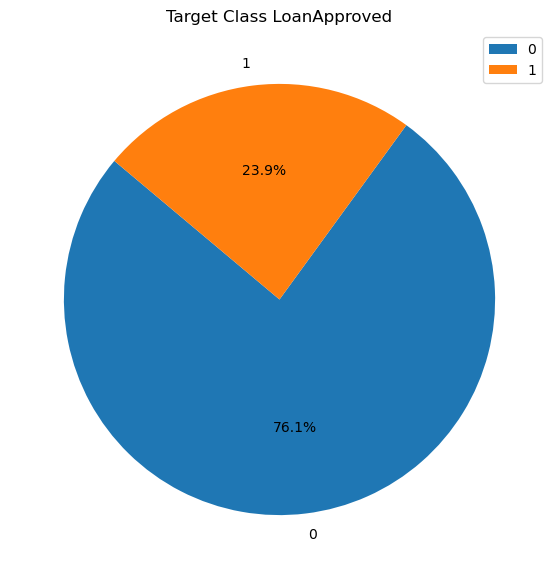

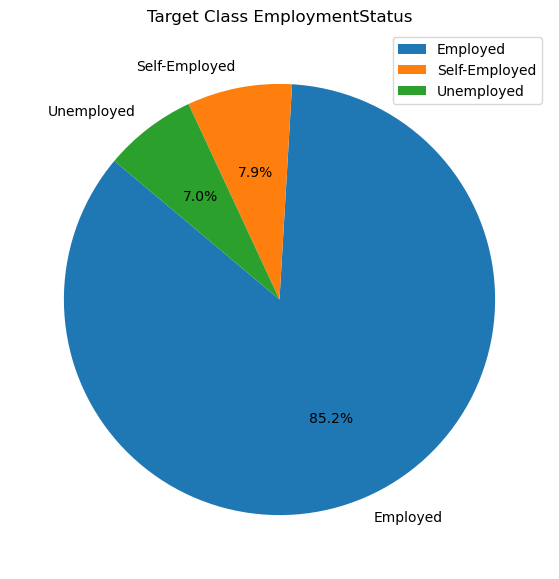

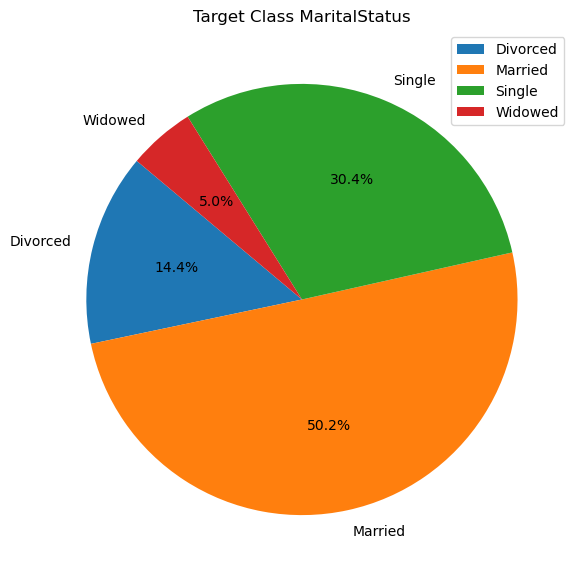

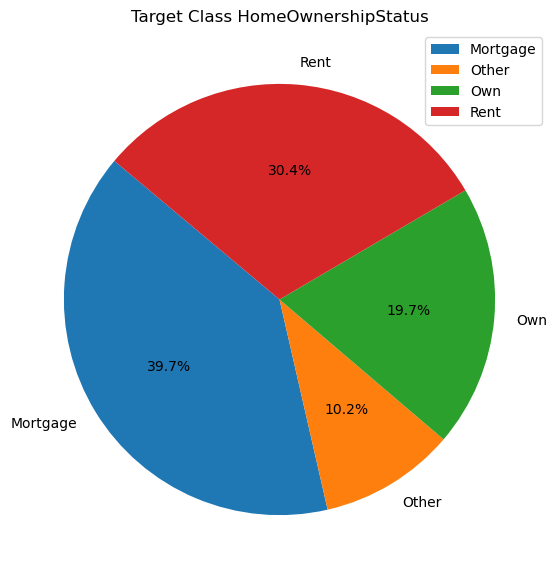

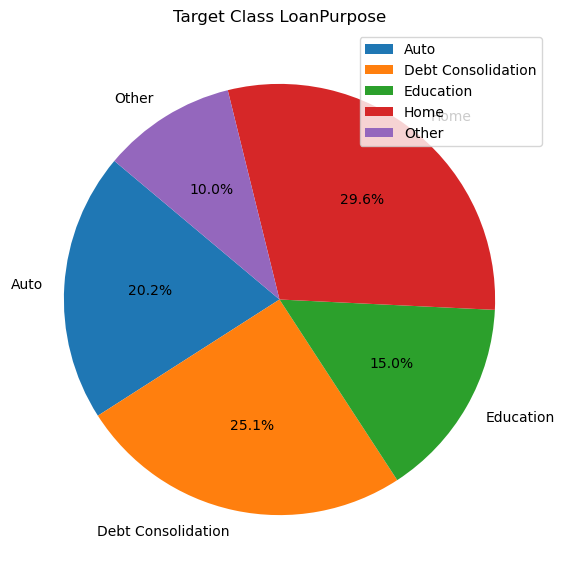

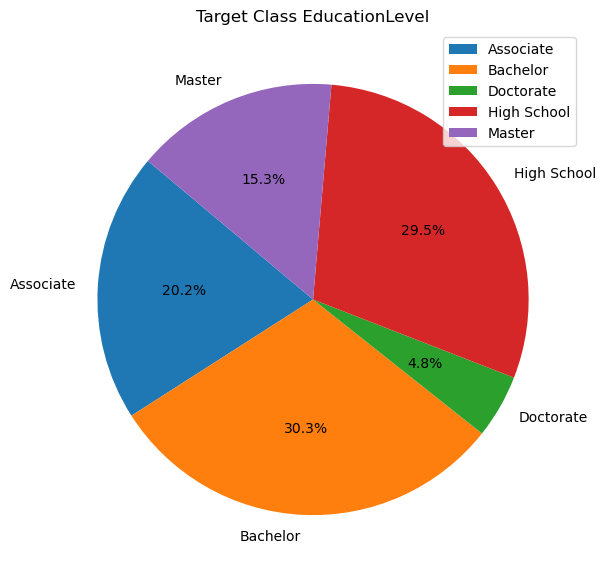

In [14]:
check_class_imbalance(df["LoanApproved"], "LoanApproved")
check_class_imbalance(df["EmploymentStatus"], "EmploymentStatus")
check_class_imbalance(df["MaritalStatus"], "MaritalStatus")
check_class_imbalance(df["HomeOwnershipStatus"], "HomeOwnershipStatus")
check_class_imbalance(df["LoanPurpose"], "LoanPurpose")
check_class_imbalance(df["EducationLevel"], "EducationLevel")

In [8]:
df.dtypes

ApplicationDate                object
Age                             int64
AnnualIncome                    int64
CreditScore                     int64
EmploymentStatus               object
EducationLevel                 object
Experience                      int64
LoanAmount                      int64
LoanDuration                    int64
MaritalStatus                  object
NumberOfDependents              int64
HomeOwnershipStatus            object
MonthlyDebtPayments             int64
CreditCardUtilizationRate     float64
NumberOfOpenCreditLines         int64
NumberOfCreditInquiries         int64
DebtToIncomeRatio             float64
BankruptcyHistory               int64
LoanPurpose                    object
PreviousLoanDefaults            int64
PaymentHistory                  int64
LengthOfCreditHistory           int64
SavingsAccountBalance           int64
CheckingAccountBalance          int64
TotalAssets                     int64
TotalLiabilities                int64
MonthlyIncom

In [15]:
categorical_types = df.select_dtypes(include="object")
numerical_types = df.select_dtypes(exclude="object")

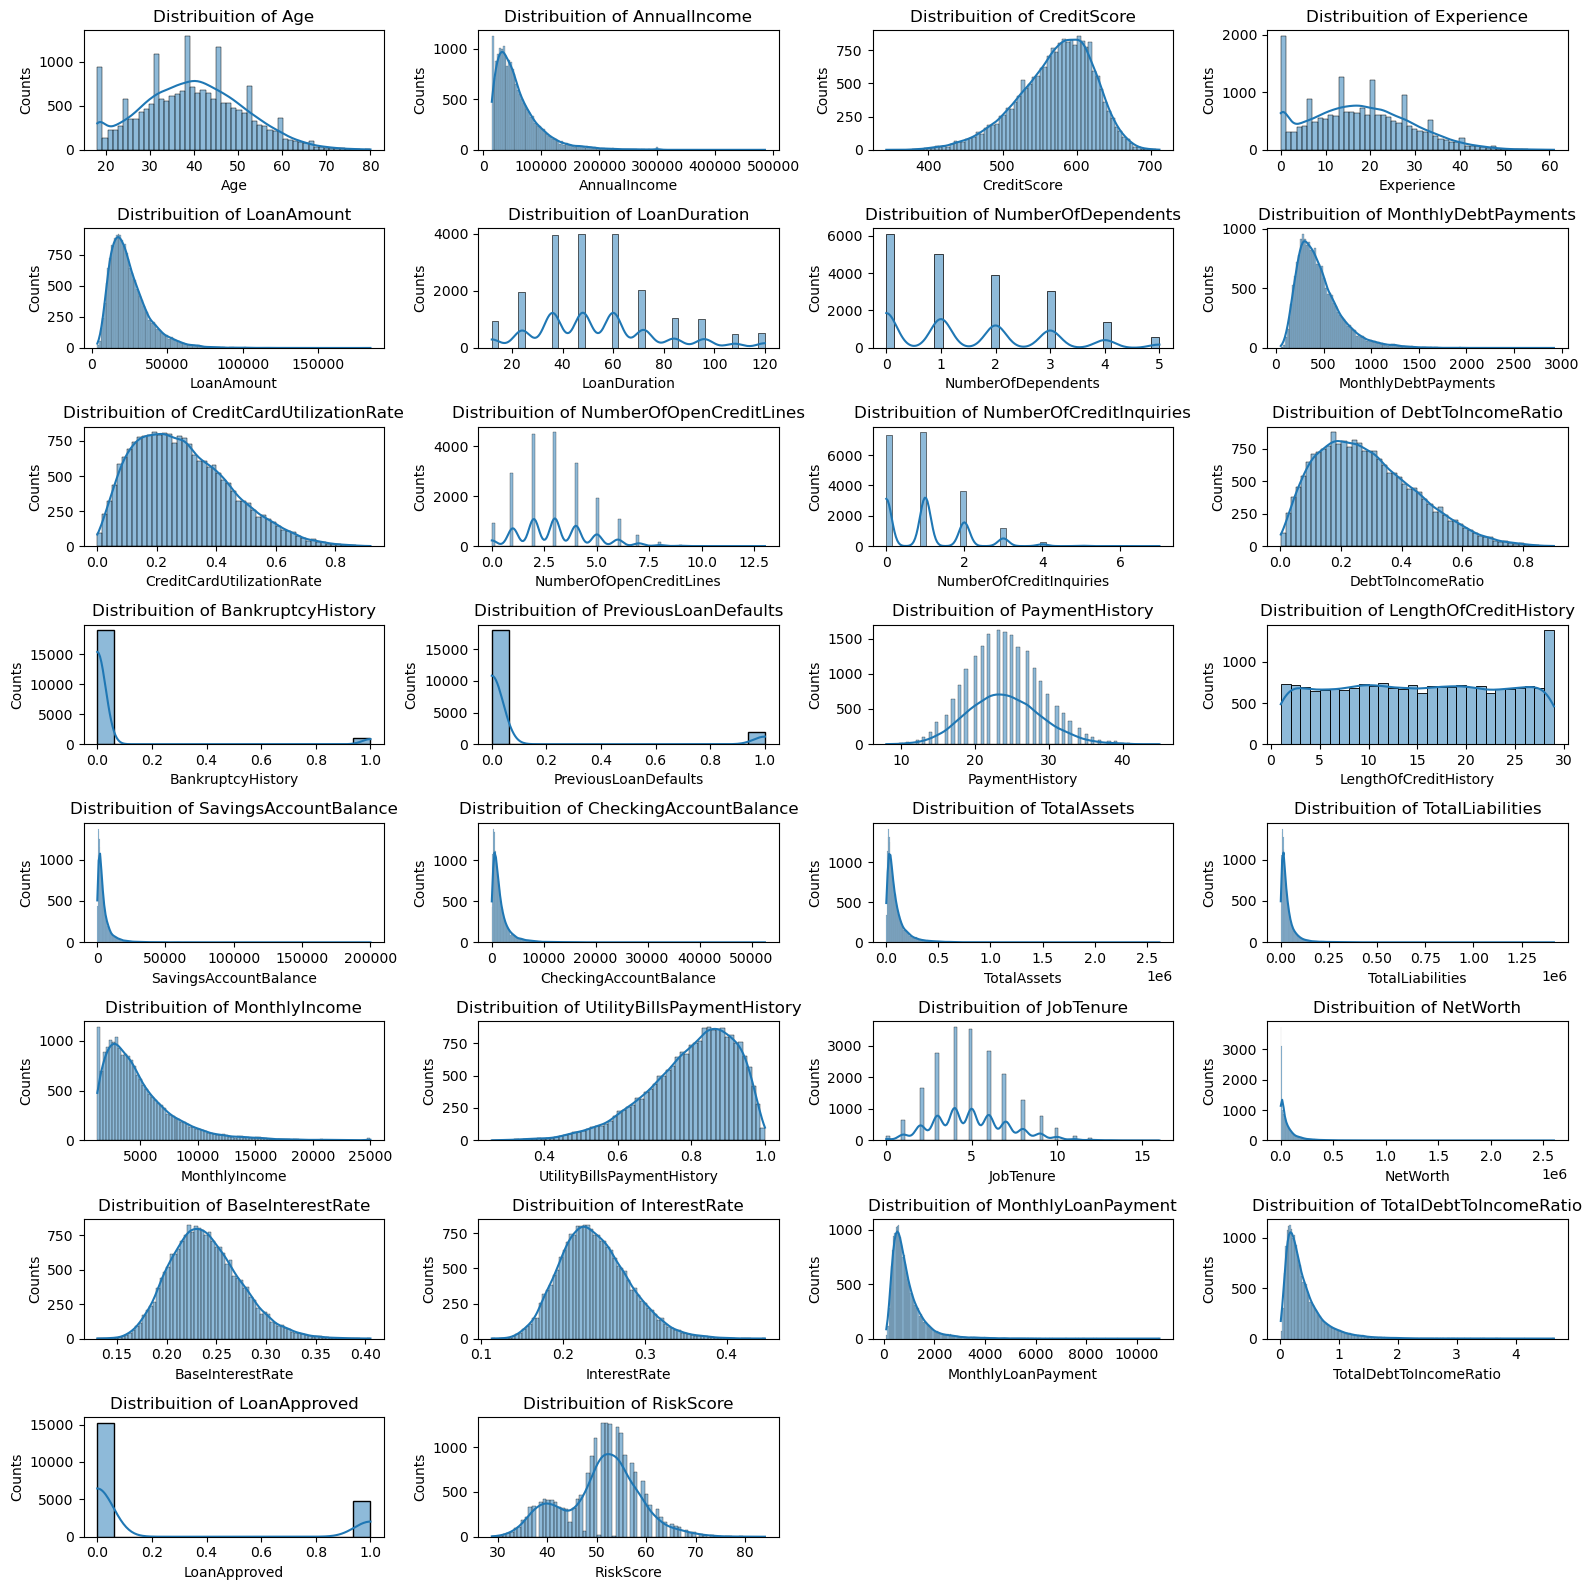

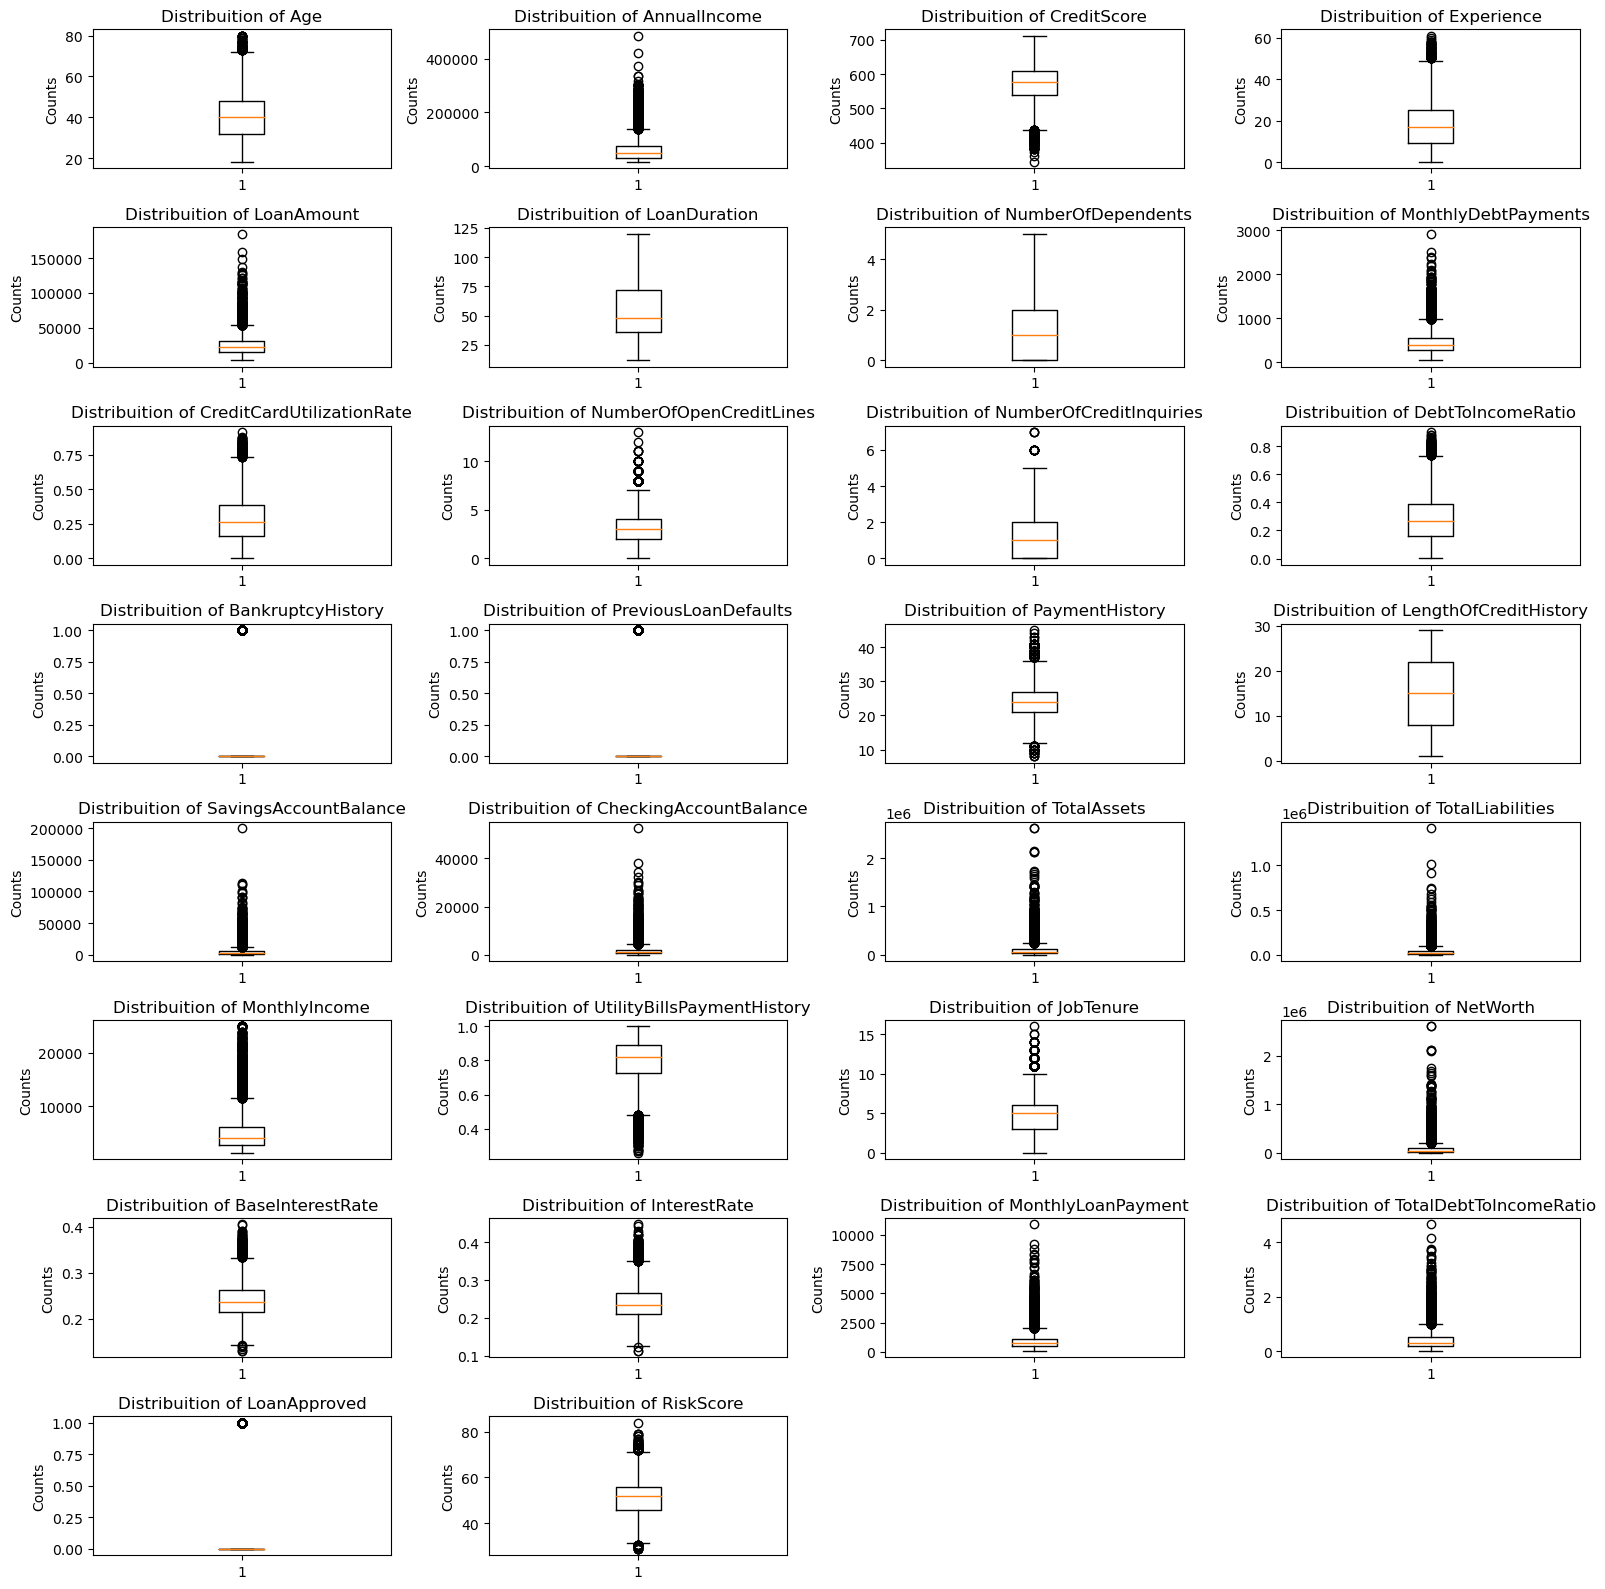

In [17]:
plot_distribution(numerical_types, "Hist")
plot_distribution(numerical_types, "boxplot")

# HeatMap

<AxesSubplot:>

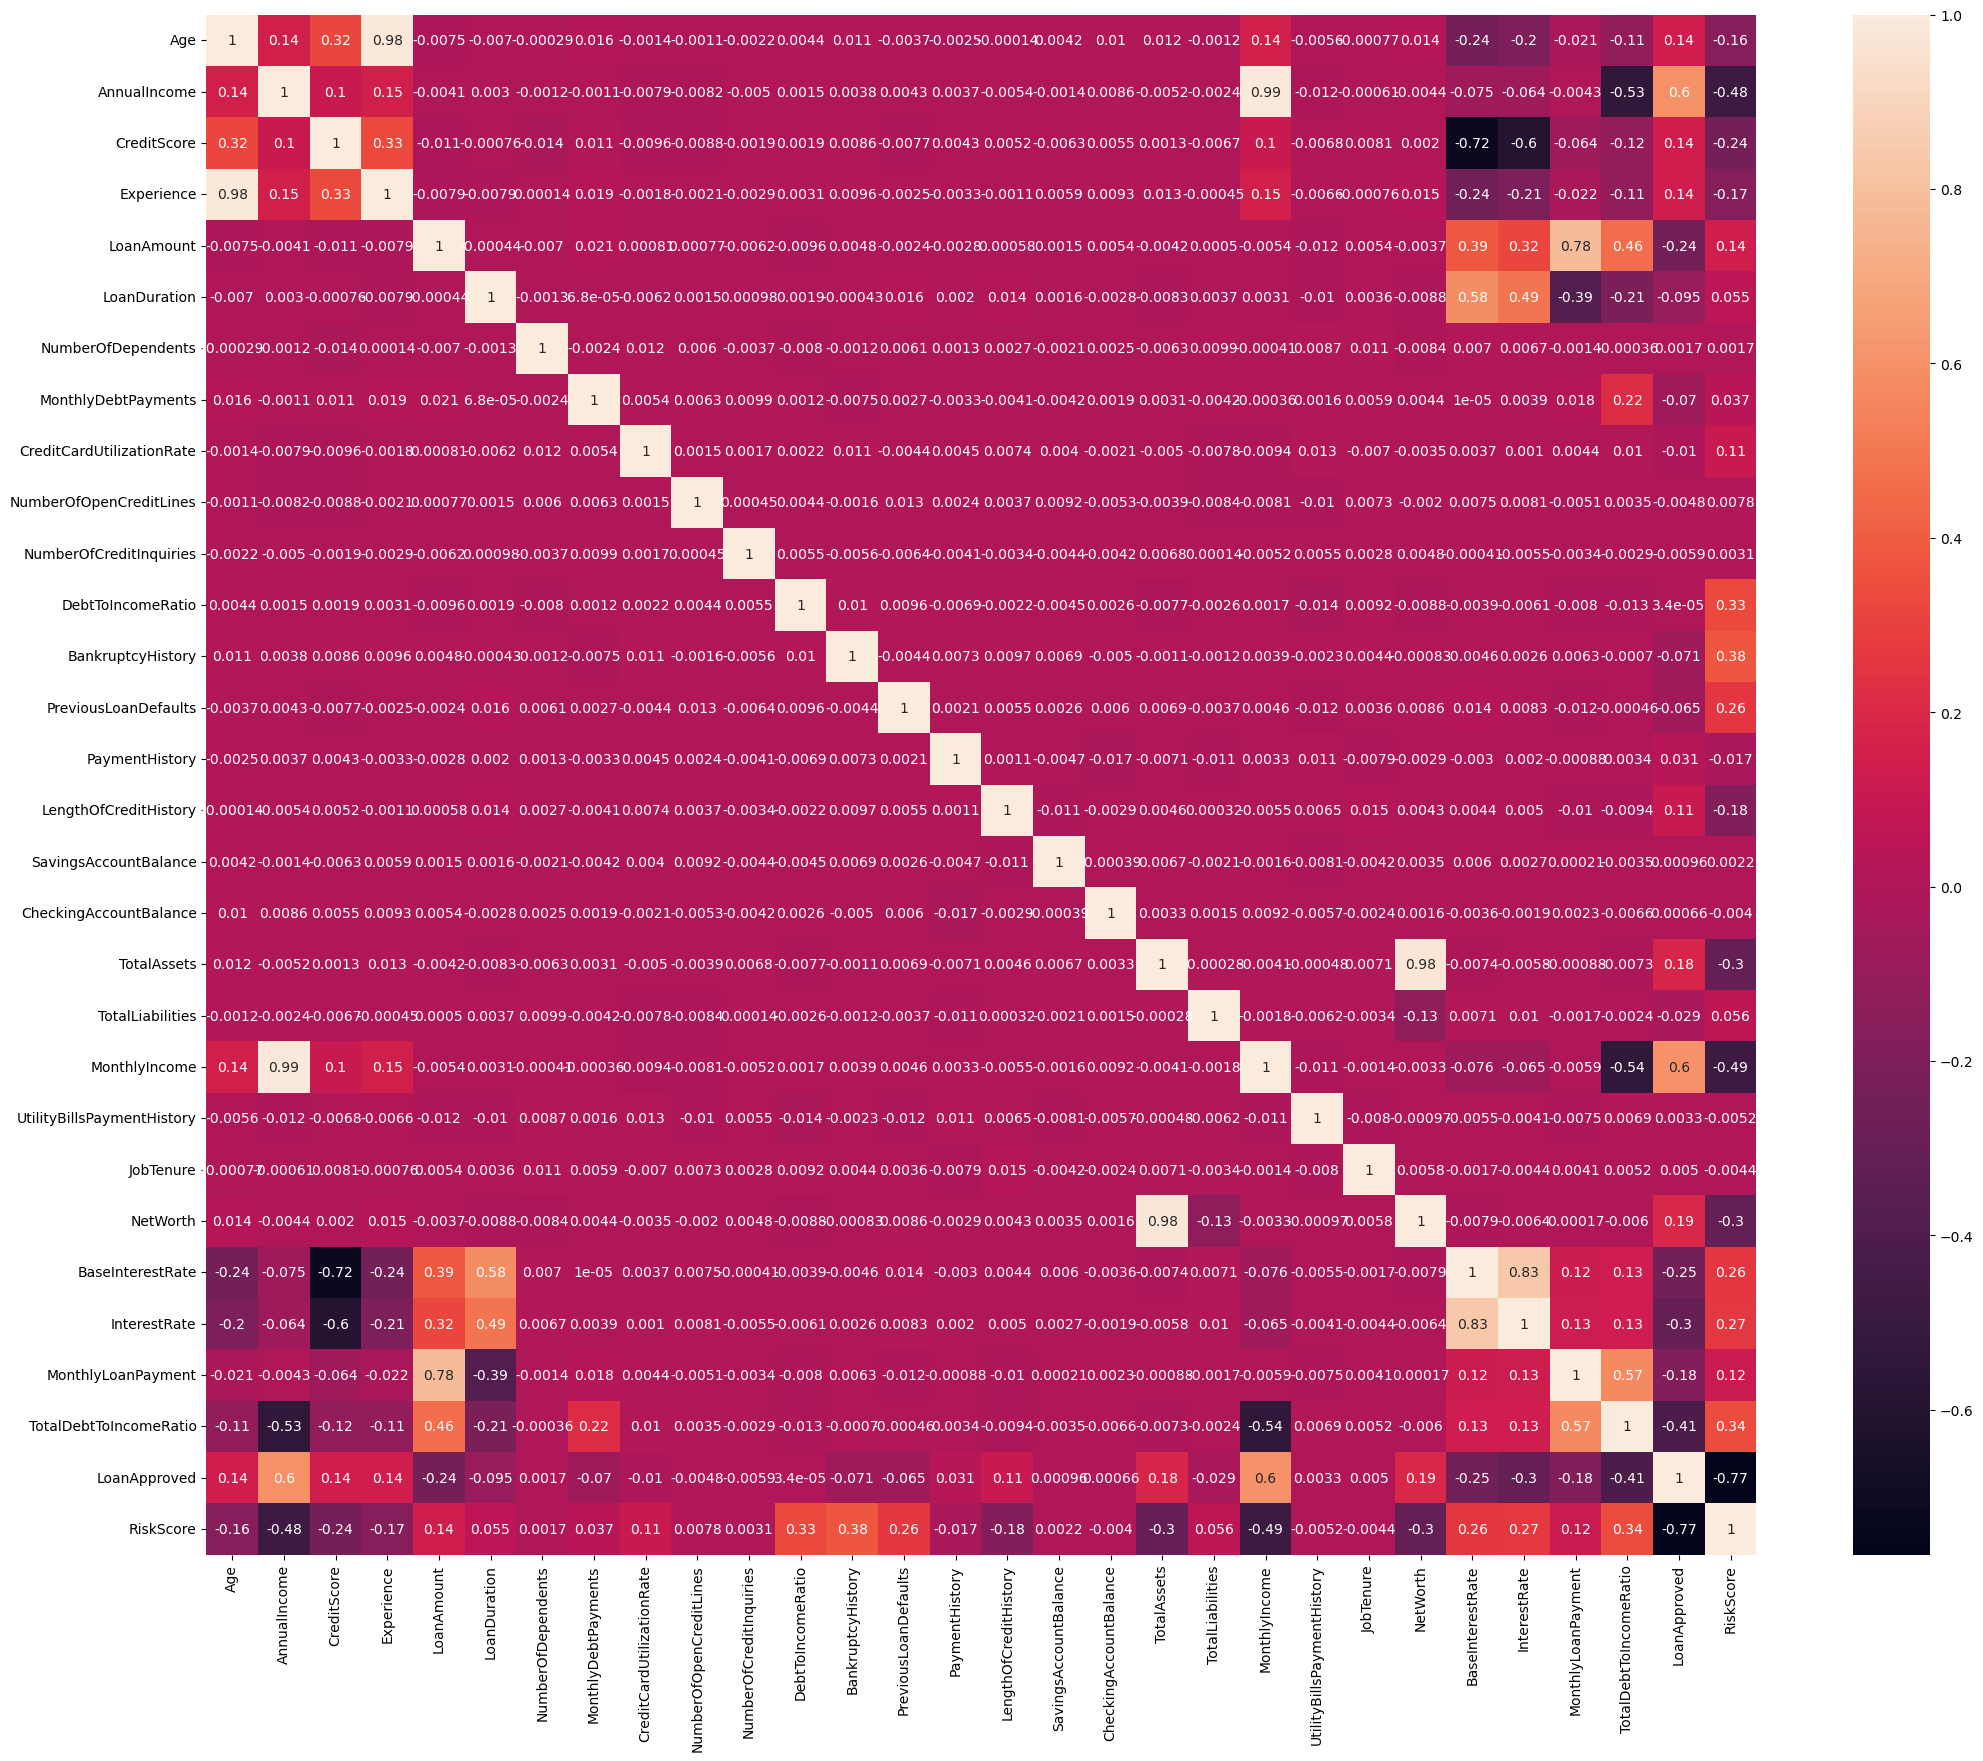

In [22]:
relations = numerical_types.corr()
plt.figure(figsize=(25, 20))
sns.heatmap(data=relations, annot=True)

# Aggregate Data

In [28]:
categorical_types.columns

Index(['ApplicationDate', 'EmploymentStatus', 'EducationLevel',
       'MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose'],
      dtype='object')

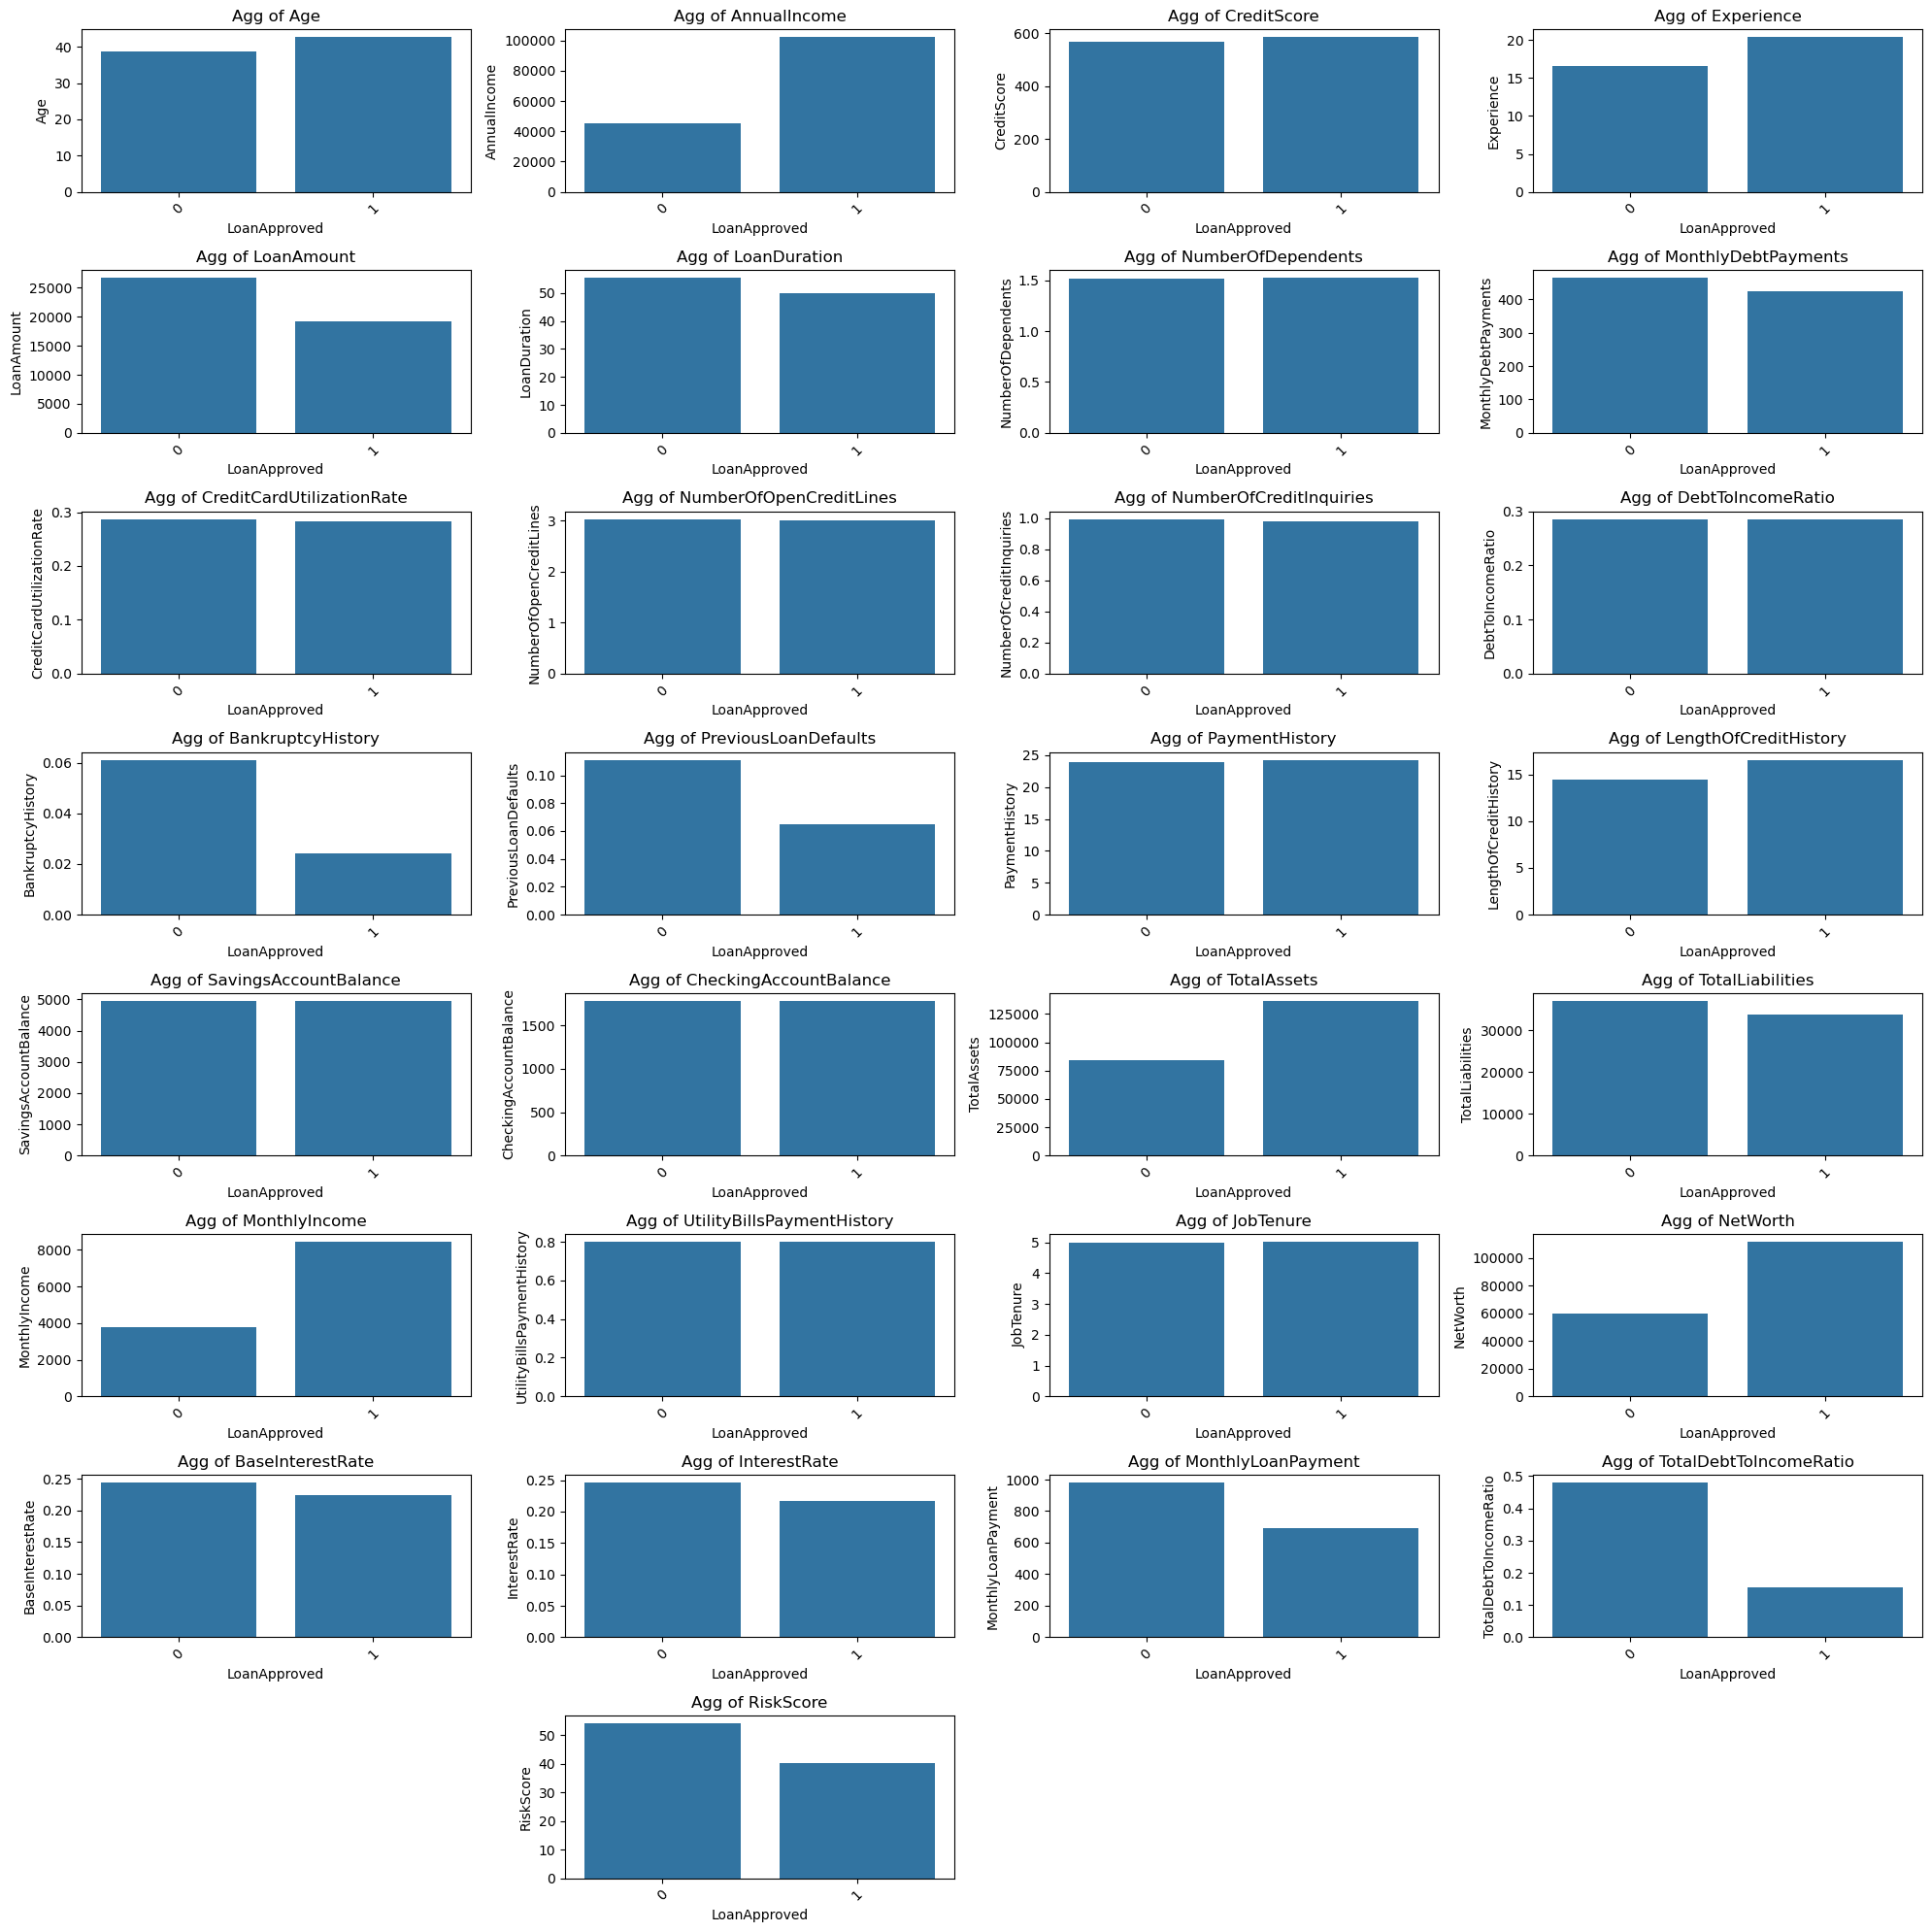

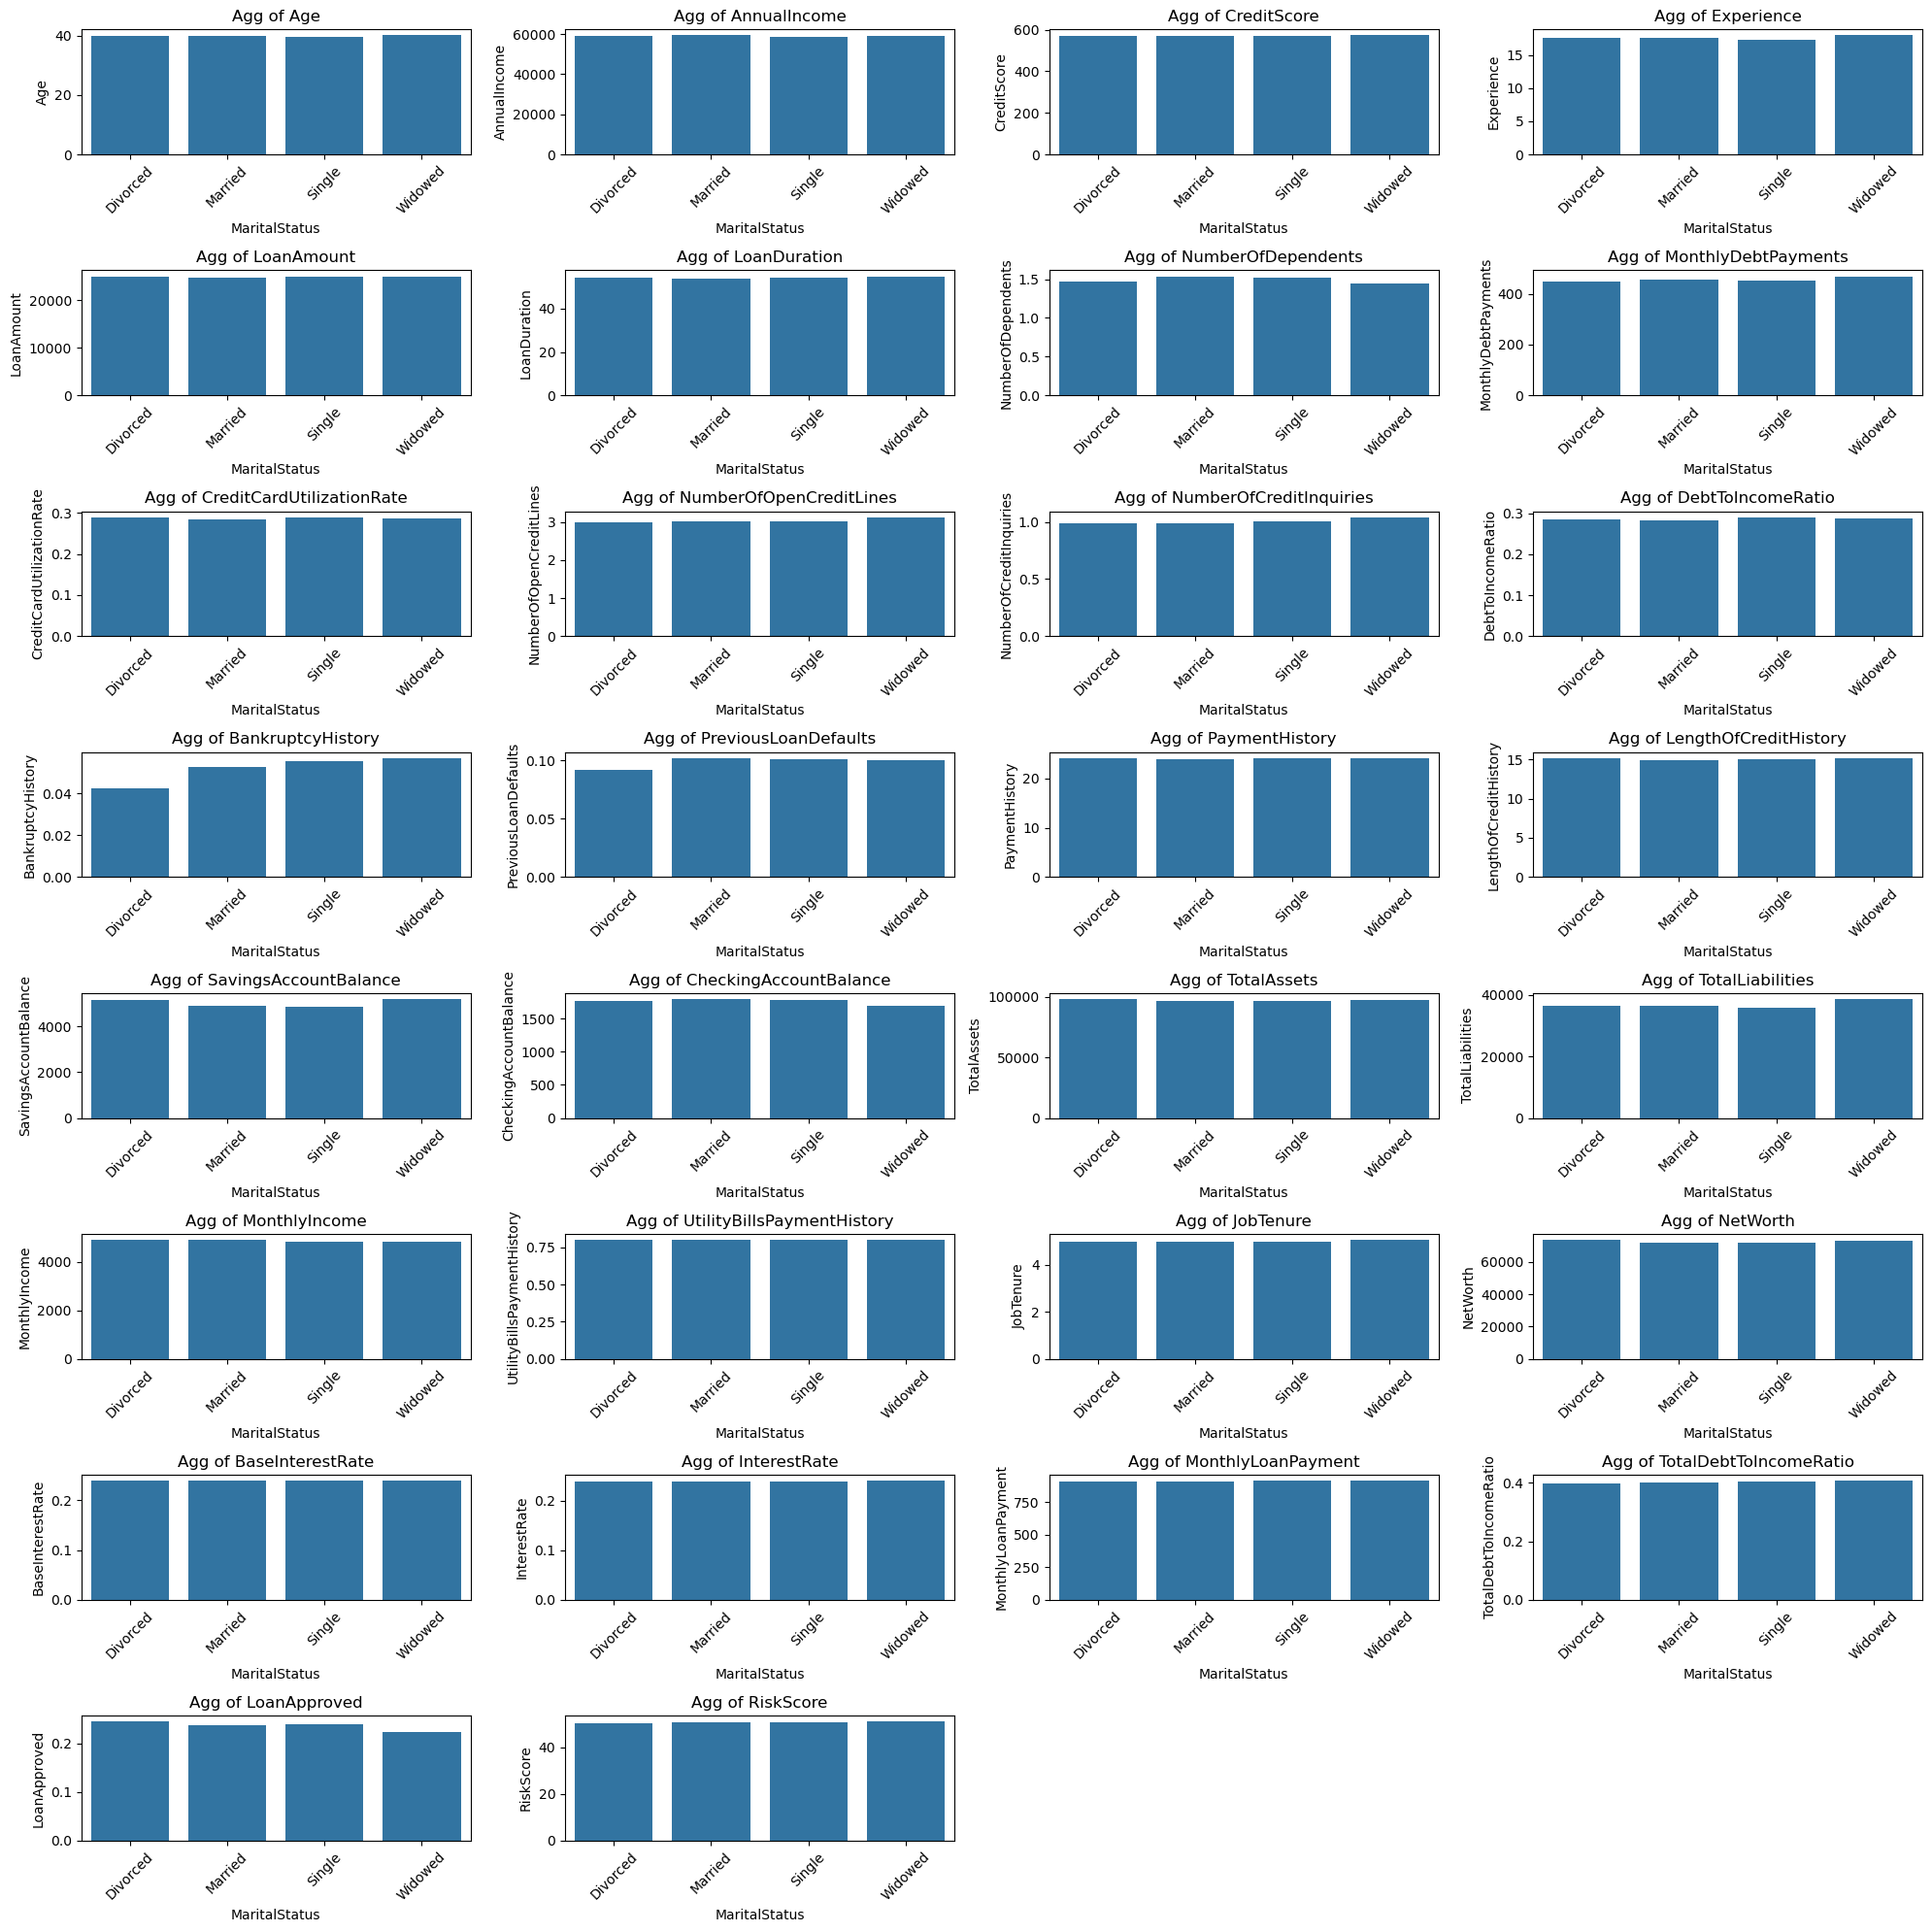

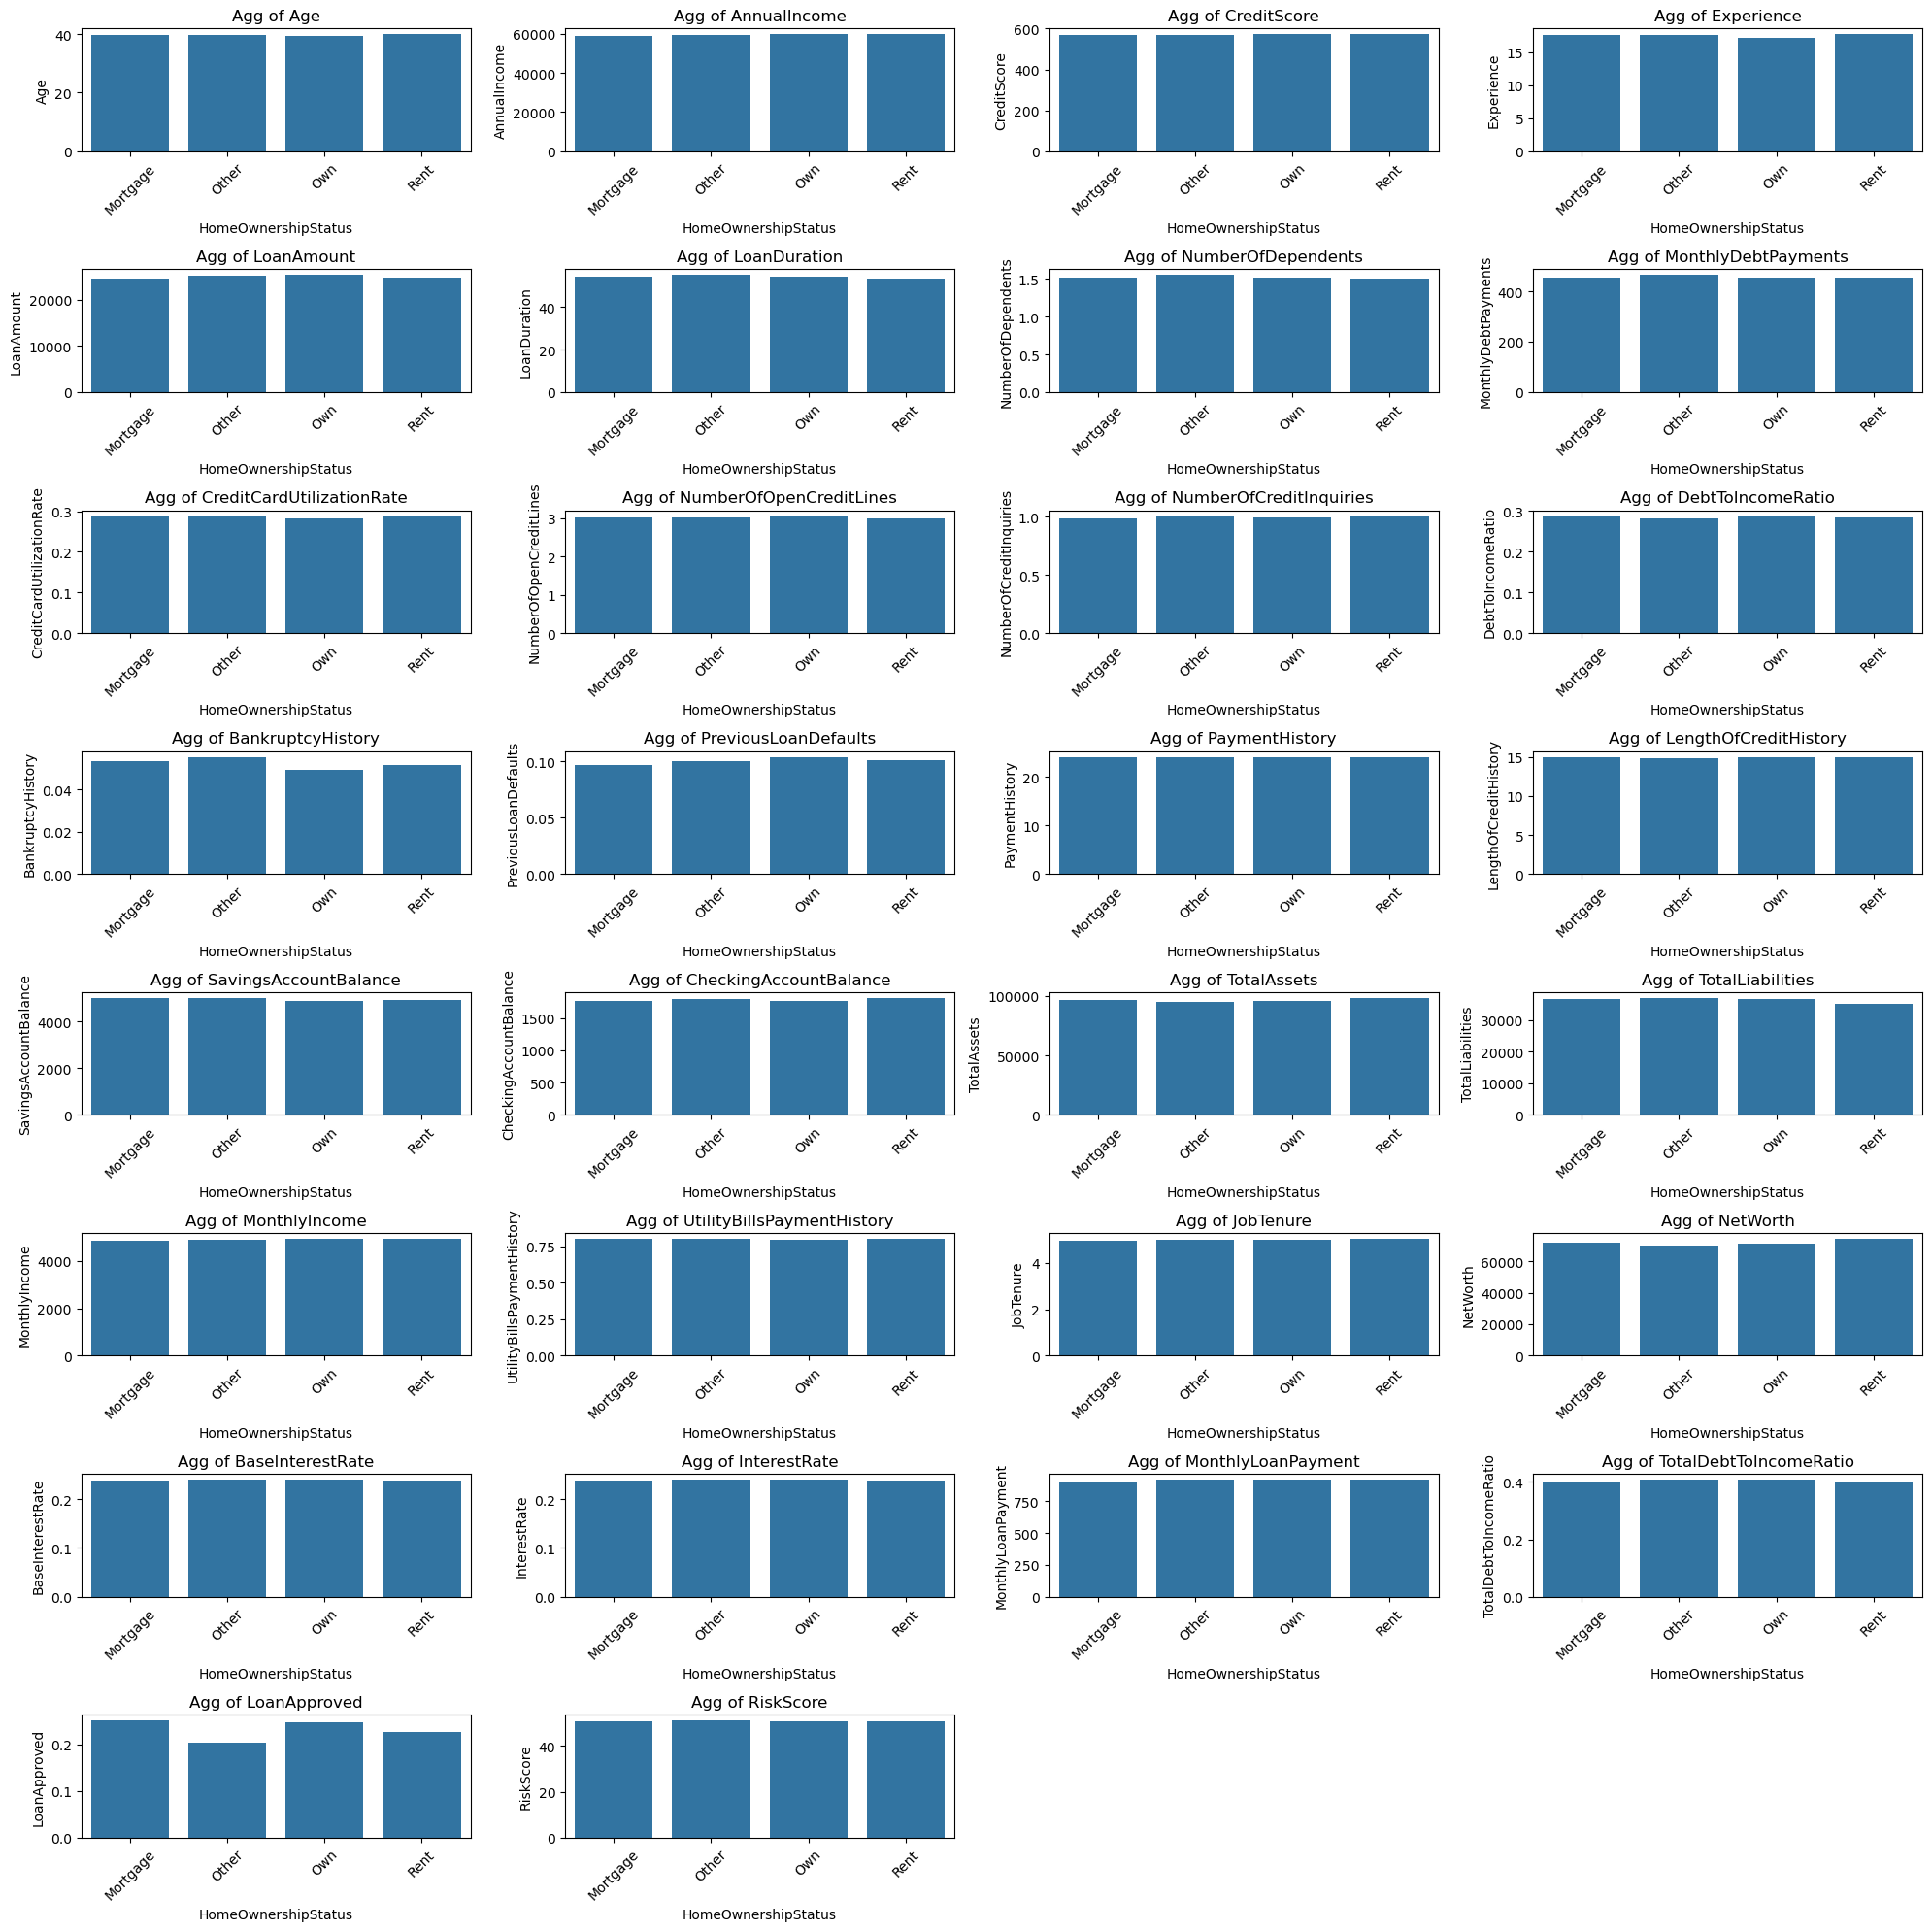

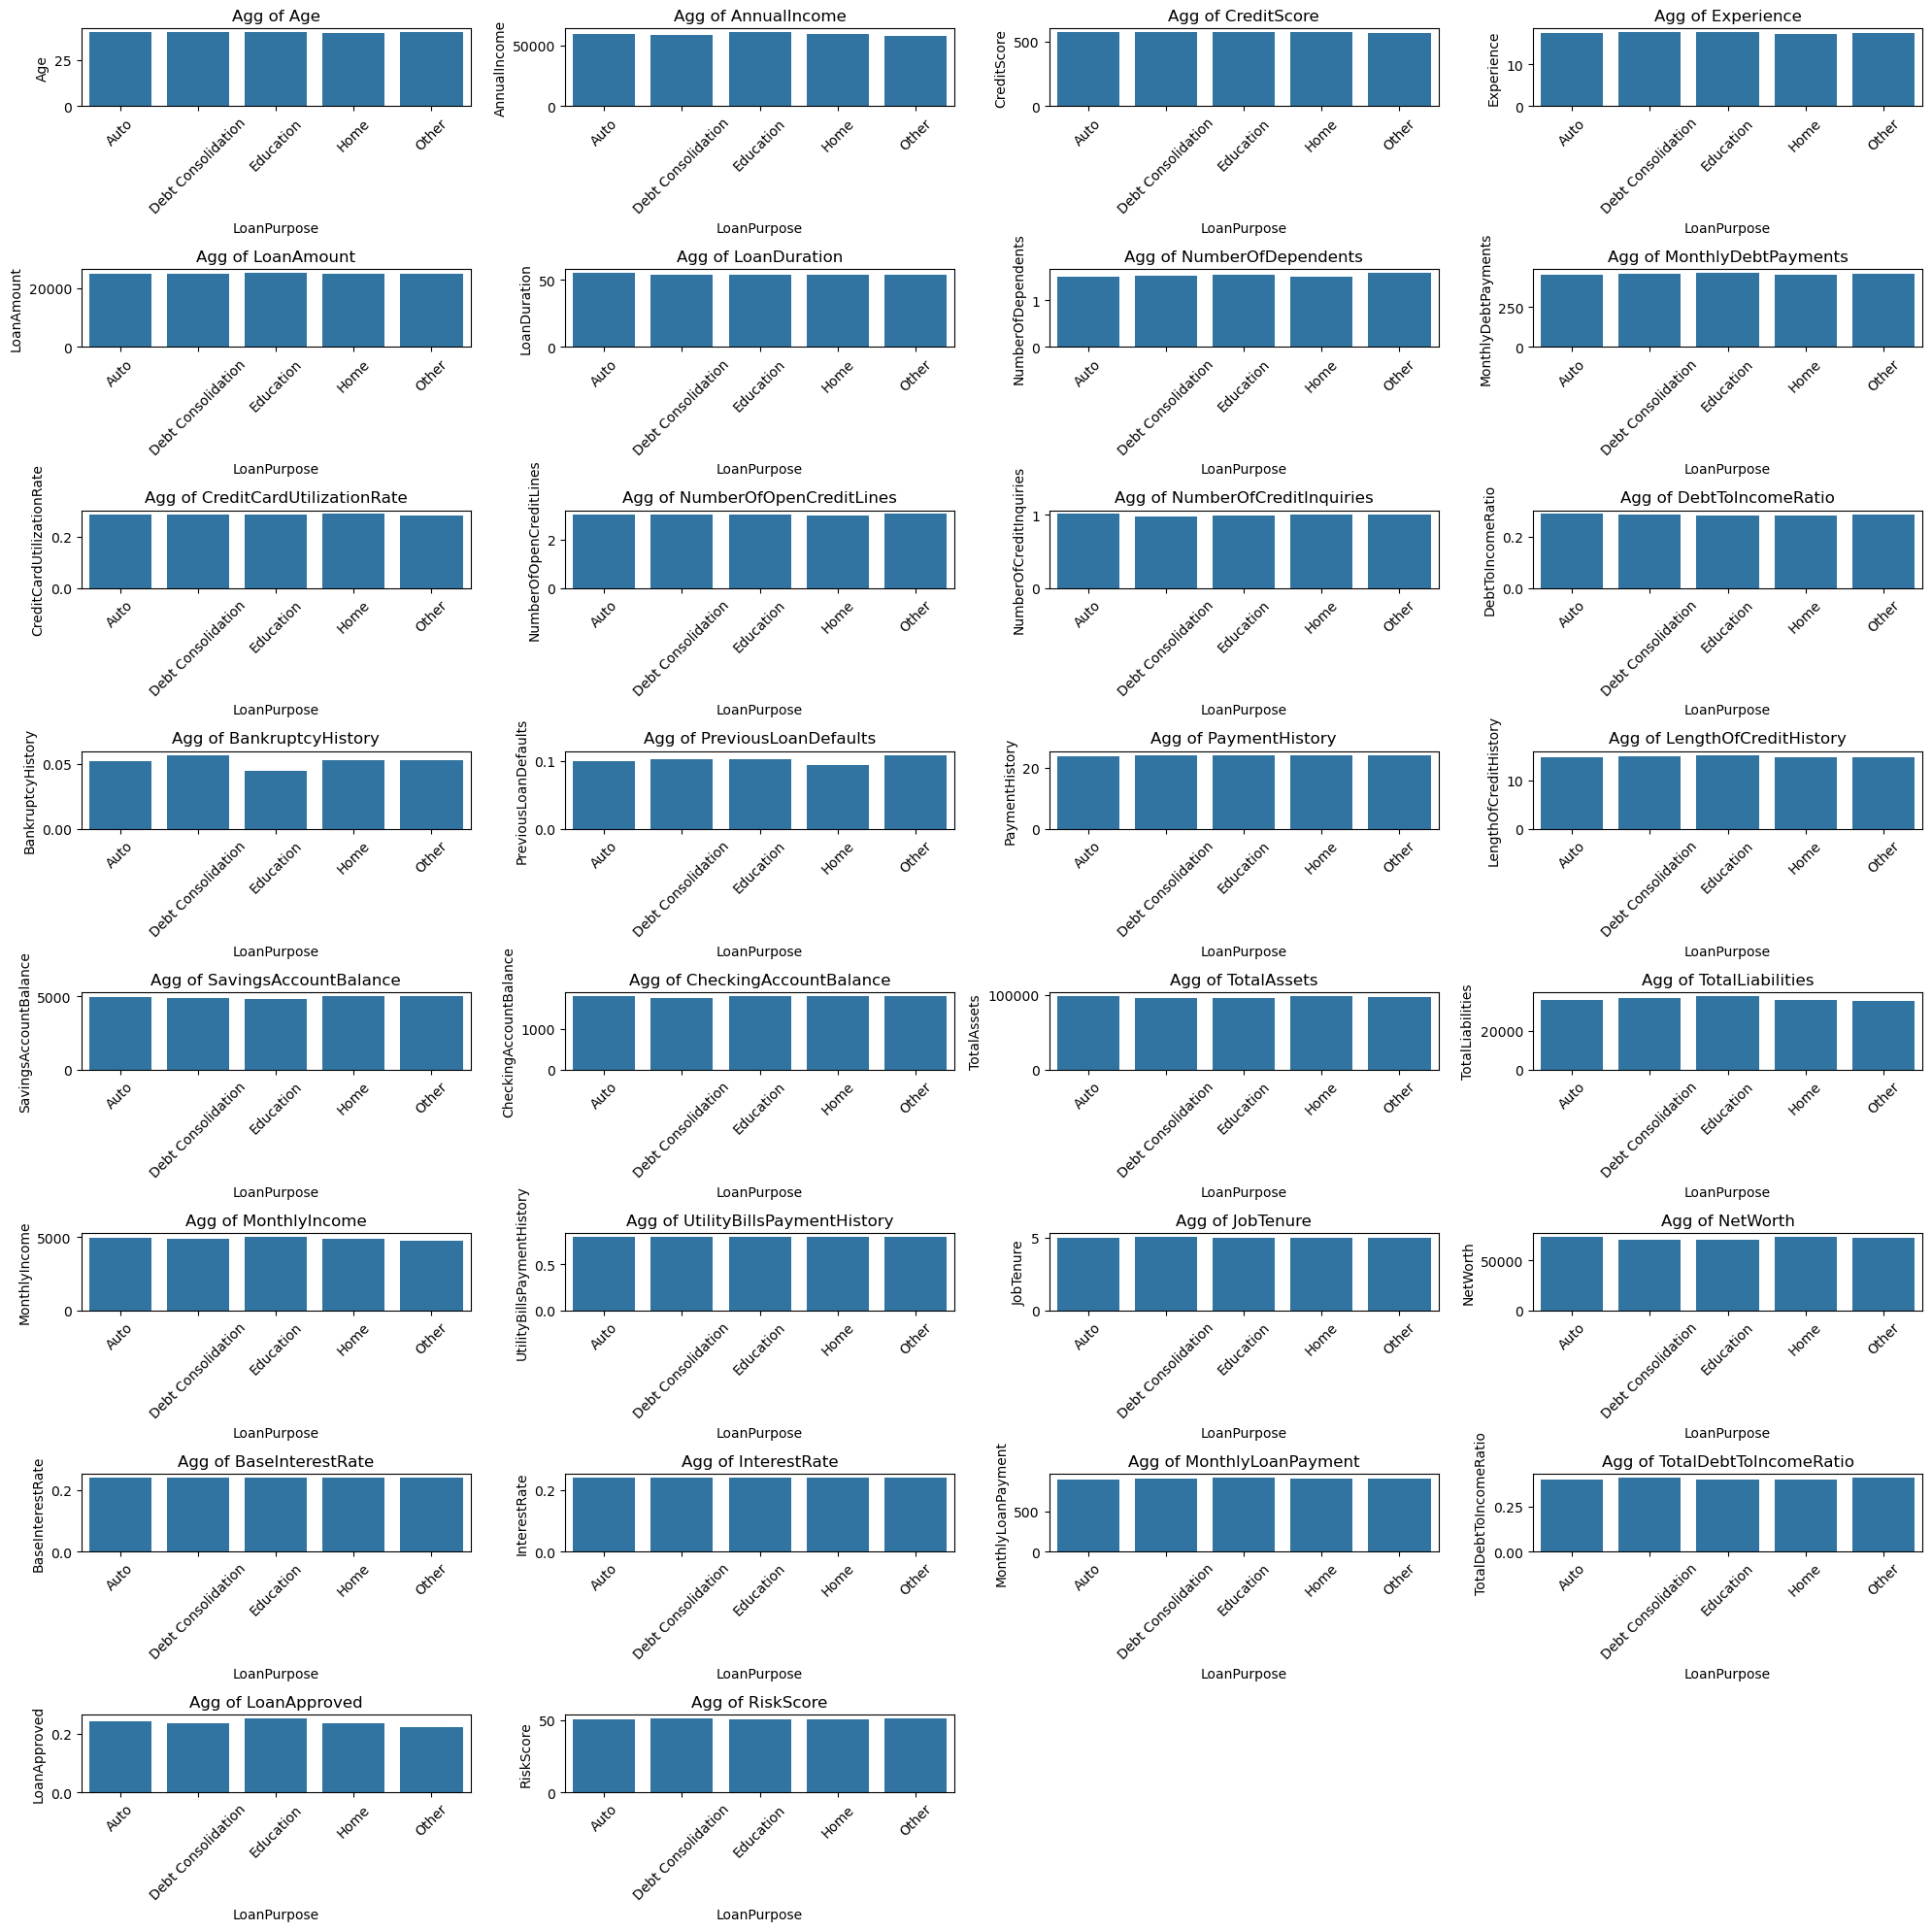

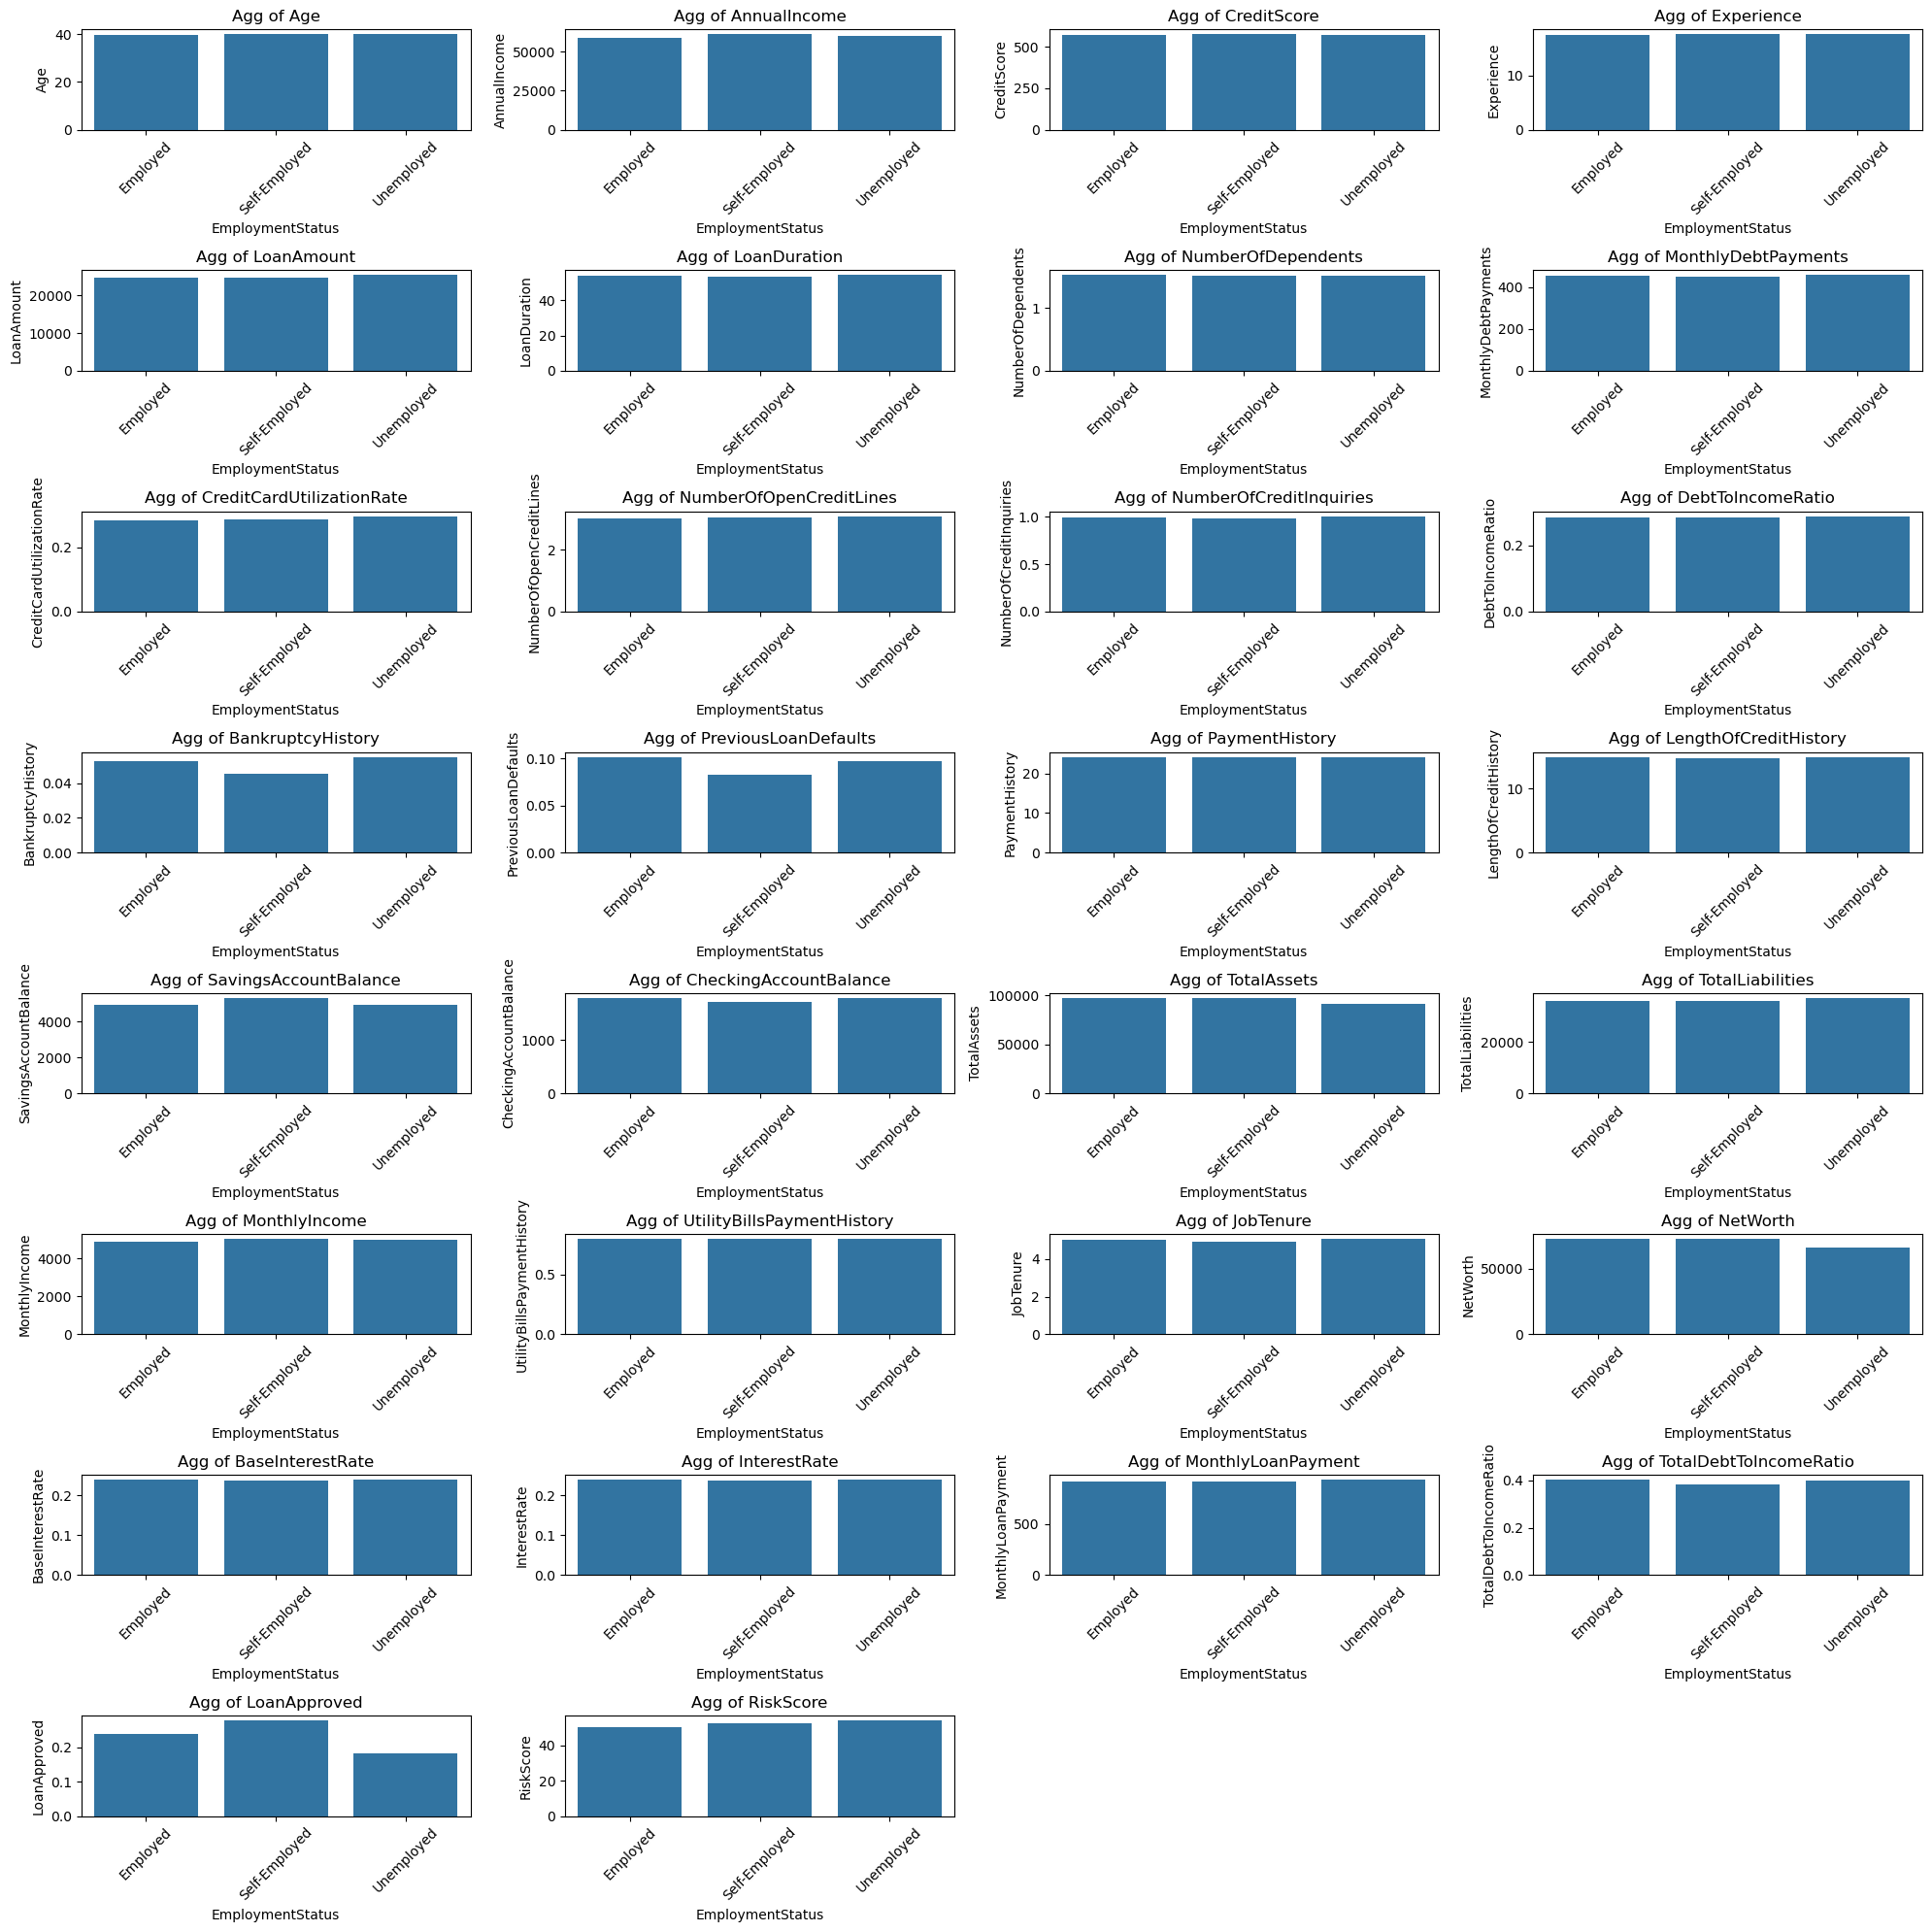

In [31]:
aggregate_dataset(df, numerical_types.columns, "LoanApproved", "mean")
aggregate_dataset(df, numerical_types.columns, "MaritalStatus", "mean")
aggregate_dataset(df, numerical_types.columns, "HomeOwnershipStatus", "mean")
aggregate_dataset(df, numerical_types.columns, "LoanPurpose", "mean")
aggregate_dataset(df, numerical_types.columns, "EmploymentStatus", "mean")